## Import Libraries

In [2]:
import pandas as pd
import requests as req  
import matplotlib.pyplot as plt
import os
import io   
import numpy as np

## Exploring with Static Data

In [3]:
# Setting folder patha and dataset
gtfs_path = "G:\My Drive\google_transit (2)"
os.listdir(gtfs_path)

['agency.txt',
 'routes.txt',
 'stops.txt',
 'feed_info.txt',
 'calendar.txt',
 'shapes.txt',
 'calendar_dates.txt',
 'directions.txt',
 'transfers.txt',
 'stop_order_exceptions.txt',
 'stop_times.txt',
 'signup_periods.txt',
 'direction_names_exceptions.txt',
 'trips.txt',
 'route_names_exceptions.txt',
 'processed',
 'realtime_data',
 'data',
 'data_processed',
 'models',
 'results',
 'CHECKPOINT_20251126_013001.txt',
 'visualizations',
 'reports',
 'backup',
 'CHECKPOINT_20251128_152816.txt',
 'CHECKPOINT_20251128152816.txt',
 'SESSION_BACKUP_20251130_180654.txt',
 'SESSION_BACKUP_20251130_184545.txt',
 'FINAL_PROJECT_CHECKPOINT_20251130_220216.txt',
 'SESSION_BACKUP_20251202_122019.txt',
 'SESSION_BACKUP_20251208_221206.txt']

## Loading core GTFS Files

In [4]:
stops = pd.read_csv(f"{gtfs_path}/stops.txt")
routes = pd.read_csv(f"{gtfs_path}/routes.txt")
trips = pd.read_csv(f"{gtfs_path}/trips.txt")
stop_times = pd.read_csv(f"{gtfs_path}/stop_times.txt")

print("Stops:", stops.shape)
print("Routes:", routes.shape)
print("Trips:", trips.shape)
print("Stop Times:", stop_times.shape)

Stops: (8818, 11)
Routes: (238, 9)
Trips: (62159, 10)
Stop Times: (1823423, 10)


Quick Checks

In [5]:
# View column names
print(stops.columns)
print(stop_times.head())

# Count unique stops and routes
print("Unique stops:", stops['stop_id'].nunique())
print("Unique routes:", routes['route_id'].nunique())

# Any missing values?
print(stop_times.isnull().sum())

Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'wheelchair_boarding'],
      dtype='object')
    trip_id arrival_time departure_time  stop_id  stop_sequence  \
0  14672431      6:16:00        6:16:00      646              1   
1  14672431      6:23:53        6:23:53     1277             10   
2  14672431      6:24:49        6:24:49     1279             11   
3  14672431      6:26:07        6:26:07       56             12   
4  14672431      6:26:41        6:26:41    12619             13   

   stop_headsign  pickup_type  drop_off_type  shape_dist_traveled  timepoint  
0            NaN            0              0                  NaN          1  
1            NaN            0              0               3.4113          0  
2            NaN            0              0               3.8104          0  
3            NaN            0              0               4.3660          0  
4  

## Exploring Dataset

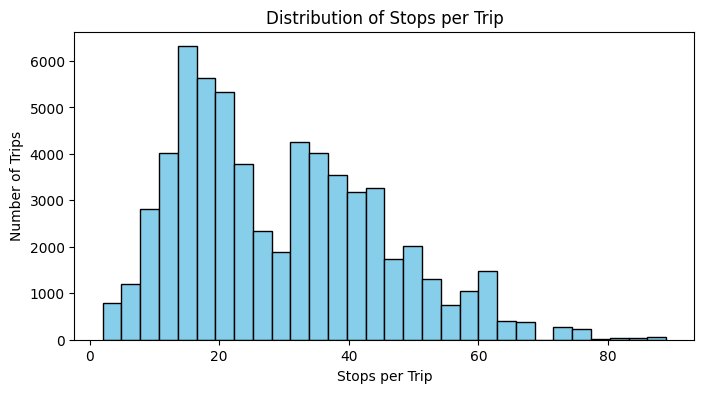

          trip_id arrival_time departure_time  stop_sequence
672281   14695892     18:38:30       18:38:30             13
1430141  14724743      5:57:27        5:57:27             13
700912   14696791     10:41:51       10:41:51             19
25917    14673153      8:11:24        8:11:24             30
1496767  14728636     15:54:00       15:54:00             12


In [6]:
# Number of stops per trip
stop_counts = stop_times.groupby('trip_id')['stop_id'].count()

plt.figure(figsize=(8,4))
plt.hist(stop_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Stops per Trip')
plt.xlabel('Stops per Trip')
plt.ylabel('Number of Trips')
plt.show()

# Sample trips and stops
sample_trips = stop_times.sample(5)
print(sample_trips[['trip_id','arrival_time','departure_time','stop_sequence']])

Most trips have between 10 and 40 stops, with a clear peak around 20 stops per trip.

This suggests that the majority of TransLink routes are short to medium-length, likely local bus routes with frequent stops.

There are fewer trips with 50+ stops, which probably correspond to longer regional or express routes.

The right tail (up to ~85 stops) shows a few outlier routes — possibly full-length lines or special services.

This helps establish network complexity — showing that most routes have moderate stop density, meaning delay propagation analysis should focus on medium-length trips (10–40 stops) where cascading delays are most likely to occur.

### Explore route length and stop density 

Average stops per route: 62.151898734177216


<Axes: title={'center': 'Top 10 Routes by Stop Count'}, xlabel='route_id'>

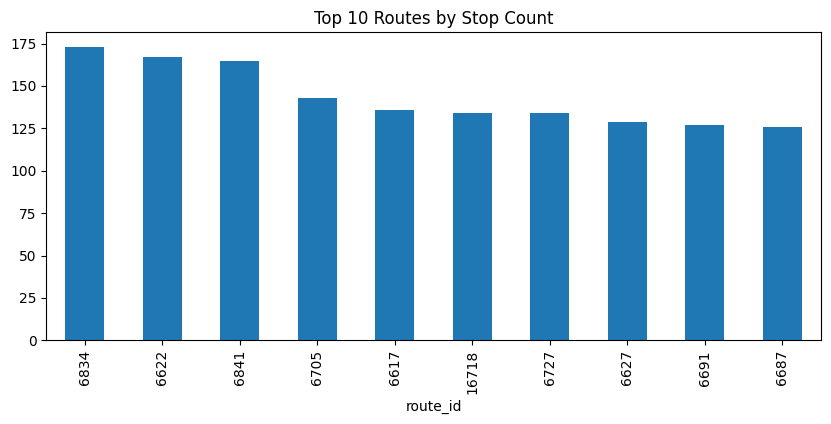

In [7]:
# Stops per route
route_stop_counts = stop_times.merge(trips[['trip_id','route_id']], on='trip_id')
route_density = route_stop_counts.groupby('route_id')['stop_id'].nunique().sort_values(ascending=False)

print("Average stops per route:", route_density.mean())
route_density.head(10).plot(kind='bar', figsize=(10,4), title='Top 10 Routes by Stop Count')


### Trip duration estimation (scheduled)

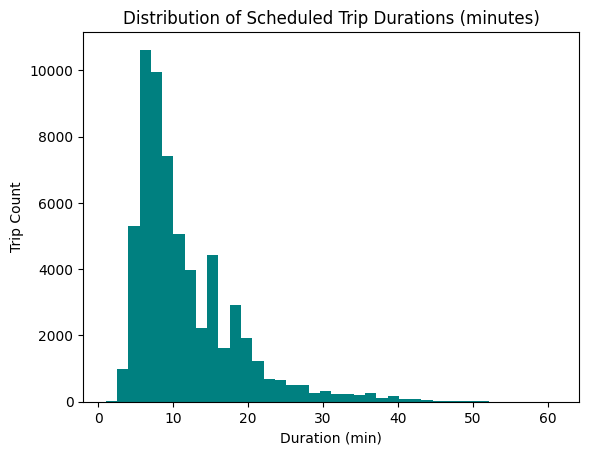

In [8]:
import datetime as dt

def time_to_seconds(t):
    h, m, s = map(int, t.split(':'))
    return h*3600 + m*60 + s

trip_duration = stop_times.groupby('trip_id').agg({
    'arrival_time': ['first','last']
})
trip_duration.columns = ['start_time','end_time']
trip_duration = trip_duration.reset_index()

trip_duration['duration_min'] = (trip_duration['end_time'].apply(time_to_seconds) -
                                 trip_duration['start_time'].apply(time_to_seconds)) / 60

plt.hist(trip_duration['duration_min'], bins=40, color='teal')
plt.title("Distribution of Scheduled Trip Durations (minutes)")
plt.xlabel("Duration (min)")
plt.ylabel("Trip Count")
plt.show()

### Analyze service time distribution

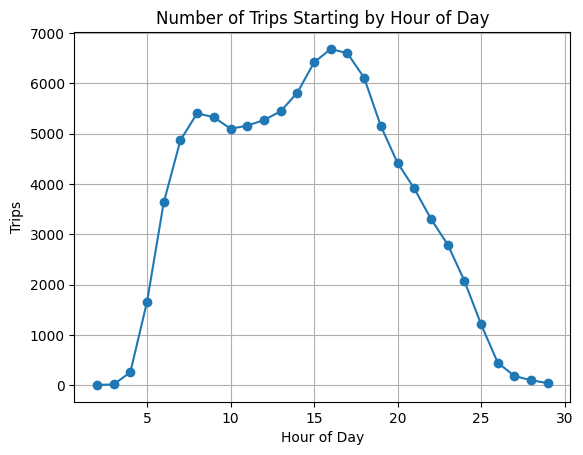

In [9]:
stop_times['hour'] = stop_times['arrival_time'].apply(lambda x: int(x.split(':')[0]) if ':' in x else None)
hourly_counts = stop_times.groupby('hour')['trip_id'].nunique()

plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.title("Number of Trips Starting by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Trips")
plt.grid(True)
plt.show()


### Visualize stop locations

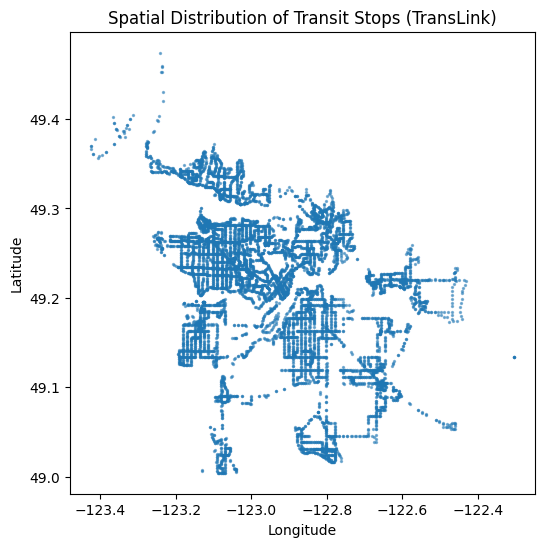

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(stops['stop_lon'], stops['stop_lat'], s=2, alpha=0.5)
plt.title("Spatial Distribution of Transit Stops (TransLink)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Create a network-level view

Count how many trips connect each pair of stops sequentially — helps understand graph density.

In [11]:
edges = stop_times[['trip_id','stop_sequence','stop_id']].sort_values(['trip_id','stop_sequence'])
edges['next_stop'] = edges.groupby('trip_id')['stop_id'].shift(-1)
edges = edges.dropna()

edge_counts = edges.groupby(['stop_id','next_stop']).size().reset_index(name='frequency')
print("Unique directed edges:", edge_counts.shape[0])
edge_counts.head()

Unique directed edges: 10053


,stop_id,next_stop,frequency
0,1,12767.0,259
1,11,12348.0,325
2,21,232.0,1
3,21,524.0,292
4,21,1283.0,233


In [13]:
# saving processed files for week 2

import os

# Path in your Drive (change folder name if needed)
processed_path = "/content/drive/MyDrive/google_transit (2)/processed2"
os.makedirs(processed_path, exist_ok=True)
print("Folder ready:", processed_path)

Folder ready: /content/drive/MyDrive/google_transit (2)/processed2


In [16]:
stops.to_csv(f"{processed_path}/stops_clean2.csv", index=False)
routes.to_csv(f"{processed_path}/routes_clean2.csv", index=False)
trips.to_csv(f"{processed_path}/trips_clean2.csv", index=False)
stop_times.to_csv(f"{processed_path}/stop_times_clean2.csv", index=False)

print("Static GTFS files saved successfully!")

Static GTFS files saved successfully!


In [17]:
# ============================================
# WEEK 2: PREPARE FOR DELAY PREDICTION
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

# Load the cleaned data
stops = pd.read_csv(f"{processed_path}/stops_clean2.csv")
routes = pd.read_csv(f"{processed_path}/routes_clean2.csv")
trips = pd.read_csv(f"{processed_path}/trips_clean2.csv")
stop_times = pd.read_csv(f"{processed_path}/stop_times_clean2.csv")

print("Data loaded successfully!")
print(f"Trips: {len(trips)}, Stop times: {len(stop_times)}")


Data loaded successfully!
Trips: 62159, Stop times: 1823423


In [18]:
# ============================================
# 1. FEATURE ENGINEERING
# ============================================

# Convert time strings to minutes since midnight for easier calculation
def time_to_minutes(time_str):
    """Convert HH:MM:SS to minutes since midnight"""
    if pd.isna(time_str):
        return None
    h, m, s = map(int, str(time_str).split(':'))
    return h * 60 + m + s/60

# Add temporal features
stop_times['arrival_min'] = stop_times['arrival_time'].apply(time_to_minutes)
stop_times['departure_min'] = stop_times['departure_time'].apply(time_to_minutes)
stop_times['dwell_time'] = stop_times['departure_min'] - stop_times['arrival_min']

# Calculate scheduled travel time to next stop
stop_times_sorted = stop_times.sort_values(['trip_id', 'stop_sequence'])
stop_times_sorted['next_arrival'] = stop_times_sorted.groupby('trip_id')['arrival_min'].shift(-1)
stop_times_sorted['scheduled_travel_time'] = stop_times_sorted['next_arrival'] - stop_times_sorted['departure_min']

# Add trip-level features
trip_features = stop_times_sorted.groupby('trip_id').agg({
    'stop_sequence': 'max',  # total stops in trip
    'scheduled_travel_time': 'sum'  # total trip duration
}).rename(columns={
    'stop_sequence': 'total_stops',
    'scheduled_travel_time': 'total_duration'
})

stop_times_enriched = stop_times_sorted.merge(trip_features, left_on='trip_id', right_index=True)

# Add time-of-day features (useful for peak/off-peak patterns)
stop_times_enriched['hour_of_day'] = (stop_times_enriched['arrival_min'] // 60).astype(int)
stop_times_enriched['is_peak_hour'] = stop_times_enriched['hour_of_day'].isin([7, 8, 9, 16, 17, 18]).astype(int)

# Add stop position in route (early/middle/late)
stop_times_enriched['relative_position'] = stop_times_enriched['stop_sequence'] / stop_times_enriched['total_stops']

print("\nFeatures created!")
print(stop_times_enriched[['trip_id', 'stop_sequence', 'hour_of_day', 'is_peak_hour',
                            'relative_position', 'scheduled_travel_time']].head())



Features created!
     trip_id  stop_sequence  hour_of_day  is_peak_hour  relative_position  \
0   14672431              1            6             0           0.033333   
11  14672431              2            6             0           0.066667   
22  14672431              3            6             0           0.100000   
24  14672431              4            6             0           0.133333   
25  14672431              5            6             0           0.166667   

    scheduled_travel_time  
0                0.766667  
11               0.566667  
22               0.816667  
24               1.366667  
25               0.933333  


In [19]:
# ============================================
# 2. CREATE DELAY TARGET VARIABLE (SIMULATED)
# ============================================

# Since we don't have real-time data yet, simulate delays based on realistic patterns
# This is a placeholder - you'll replace this with actual data in Week 3

np.random.seed(42)

# Simulate delays with realistic patterns:
# - More delays during peak hours
# - More delays later in routes (accumulation)
# - Some random variation

def simulate_delay(row):
    """Simulate realistic delay patterns (in minutes)"""
    base_delay = 0

    # Peak hour effect (0-3 min extra delay)
    if row['is_peak_hour']:
        base_delay += np.random.uniform(0, 3)
        # Route position effect (delays accumulate)
    base_delay += row['relative_position'] * np.random.uniform(0, 2)

    # Random variation
    base_delay += np.random.normal(0, 1)

    # Ensure non-negative, round to 1 decimal
    return max(0, round(base_delay, 1))

stop_times_enriched['simulated_delay'] = stop_times_enriched.apply(simulate_delay, axis=1)

print(f"\nDelay statistics:")
print(f"Mean delay: {stop_times_enriched['simulated_delay'].mean():.2f} minutes")
print(f"Max delay: {stop_times_enriched['simulated_delay'].max():.2f} minutes")
print(f"% on time (< 1 min): {(stop_times_enriched['simulated_delay'] < 1).mean() * 100:.1f}%")



Delay statistics:
Mean delay: 1.21 minutes
Max delay: 8.30 minutes
% on time (< 1 min): 50.6%


In [20]:
# ===========================================
# Integrate Historical Weather Data (Vancouver)
# ===========================================
import requests
from datetime import datetime

def get_vancouver_weather(start_date, end_date):
    """Fetch hourly weather data for Vancouver using Open-Meteo API."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 49.2827,
        "longitude": -123.1207,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m",
            "precipitation",
            "rain",
            "snowfall",
            "windspeed_10m",
            "visibility",
            "weathercode"
        ],
        "timezone": "America/Vancouver"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        weather_df = pd.DataFrame({
            'datetime': pd.to_datetime(data['hourly']['time']),
            'temperature': data['hourly']['temperature_2m'],
            'precipitation': data['hourly']['precipitation'],
            'rain': data['hourly']['rain'],
            'snowfall': data['hourly']['snowfall'],
            'windspeed': data['hourly']['windspeed_10m'],
            'visibility': data['hourly']['visibility'],
            'weather_code': data['hourly']['weathercode']
        })
        return weather_df
    else:
        print(f"Error fetching weather: {response.status_code}")
        return None

In [23]:
# ================================
# Fetch and Merge Weather Features
# ================================
weather = get_vancouver_weather("2024-10-01", "2024-10-31")

if weather is not None:
    # Ensure datetime formats match
    def parse_gtfs_time(t):
        """Convert GTFS HH:MM:SS (possibly >24h) to timedelta."""
        h, m, s = map(int, t.split(":"))
        extra_day = h // 24
        h = h % 24
        return timedelta(days=extra_day, hours=h, minutes=m, seconds=s)

    base_date = datetime(2024, 10, 1)
    stop_times["datetime"] = [
        base_date + parse_gtfs_time(t) for t in stop_times["arrival_time"]
    ]

    # Merge nearest-hour weather
    weather["datetime"] = pd.to_datetime(weather["datetime"])
    stop_times = pd.merge_asof(
        stop_times.sort_values("datetime"),
        weather.sort_values("datetime"),
        on="datetime",
        direction="nearest"
    )

    print("Weather data merged successfully!")
    print(stop_times[["datetime", "temperature", "rain", "windspeed"]].head())

else:
    print(" Weather data not available.")

Weather data merged successfully!
             datetime  temperature  rain  windspeed
0 2024-10-01 02:58:00         10.6   0.0        4.0
1 2024-10-01 02:59:00         10.6   0.0        4.0
2 2024-10-01 02:59:00         10.6   0.0        4.0
3 2024-10-01 02:59:00         10.6   0.0        4.0
4 2024-10-01 02:59:38         10.6   0.0        4.0


In [24]:
# ==================================================
# Recreate engineered features inside stop_times
# ==================================================

# 1️ Hour of day
stop_times['hour_of_day'] = pd.to_datetime(stop_times['arrival_time'], errors='coerce').dt.hour

# 2️ Peak hour flag (example: 7–9 AM or 4–6 PM)
stop_times['is_peak_hour'] = stop_times['hour_of_day'].isin([7, 8, 9, 16, 17, 18]).astype(int)

# 3️ Total stops per trip
stop_counts = stop_times.groupby('trip_id')['stop_id'].transform('count')
stop_times['total_stops'] = stop_counts

# 4️  Relative stop position (progress along trip)
stop_times['relative_position'] = stop_times['stop_sequence'] / stop_times['total_stops']

# 5️ Scheduled travel time (minutes since trip start)
stop_times['scheduled_travel_time'] = (
    pd.to_timedelta(stop_times['arrival_time']) - 
    pd.to_timedelta(stop_times.groupby('trip_id')['arrival_time'].transform('first'))
).dt.total_seconds() / 60.0

# 6️ Dwell time (optional: placeholder if missing)
if 'dwell_time' not in stop_times.columns:
    stop_times['dwell_time'] = 0

# 7️ Target variable placeholder (if not yet created)
if 'simulated_delay' not in stop_times.columns:
    stop_times['simulated_delay'] = np.random.normal(0, 2, len(stop_times))

print("Added derived features successfully:")
print(stop_times[['trip_id', 'stop_sequence', 'hour_of_day', 'is_peak_hour', 'total_stops', 'relative_position']].head())


C:\Users\hemal\AppData\Local\Temp\ipykernel_40324\1173218749.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stop_times['hour_of_day'] = pd.to_datetime(stop_times['arrival_time'], errors='coerce').dt.hour


Added derived features successfully:
    trip_id  stop_sequence  hour_of_day  is_peak_hour  total_stops  \
0  14677297              1          NaN             0           37   
1  14677090              1          NaN             0           39   
2  14677297              2          NaN             0           37   
3  14677476              1          NaN             0           37   
4  14677297              3          NaN             0           37   

   relative_position  
0           0.027027  
1           0.025641  
2           0.054054  
3           0.027027  
4           0.081081  


In [25]:
# ============================================
# 3. TRAIN/TEST SPLIT (with Weather Features)
# ============================================

# Select features for modeling
feature_cols = [
    'stop_sequence',
    'total_stops',
    'hour_of_day',
    'is_peak_hour',
    'relative_position',
    'scheduled_travel_time',
    'dwell_time',
    'temperature',
    'precipitation',
    'rain',
    'snowfall',
    'windspeed'
]

# Remove rows with missing values in features or target
model_data = stop_times[feature_cols + ['simulated_delay']].dropna()

print(f"\nTotal samples for modeling: {len(model_data)}")

# Split: 80% train, 20% test
# Use stratified split by hour_of_day to ensure time coverage
X = model_data[feature_cols]
y = model_data['simulated_delay']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=model_data['hour_of_day']  # keep time-of-day balance
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")



Total samples for modeling: 1331812

Train set: 1065449 samples
Test set: 266363 samples


In [26]:
# ============================================
# 5. BASIC STATISTICS FOR REPORT
# ============================================

print("\n" + "="*50)
print("DATASET STATISTICS FOR MODELING")
print("="*50)

# Summary of feature ranges
print(f"\nFeature Ranges:")
for col in feature_cols:
    col_min = X[col].min()
    col_max = X[col].max()
    print(f"{col:25s}: {col_min:.2f} - {col_max:.2f}")

# Peak-hour distribution (check if column exists)
if 'is_peak_hour' in model_data.columns:
    print(f"\nPeak Hour Distribution:")
    print(f"Peak hours: {(model_data['is_peak_hour'] == 1).sum()} samples")
    print(f"Off-peak hours: {(model_data['is_peak_hour'] == 0).sum()} samples")

# Weather summaries
weather_feats = ['temperature', 'precipitation', 'rain', 'snowfall', 'windspeed']
print(f"\nWeather Feature Averages:")
for w in weather_feats:
    if w in X.columns:
        print(f"{w:25s}: mean={X[w].mean():.2f}, std={X[w].std():.2f}")

# Target variable summary
print(f"\nTarget Variable (Delay):")
print(f"Mean: {y.mean():.2f} min")
print(f"Std Dev: {y.std():.2f} min")
print(f"Median: {y.median():.2f} min")
print(f"95th percentile: {y.quantile(0.95):.2f} min")


DATASET STATISTICS FOR MODELING

Feature Ranges:
stop_sequence            : 1.00 - 75.00
total_stops              : 2.00 - 83.00
hour_of_day              : 10.00 - 23.00
is_peak_hour             : 0.00 - 1.00
relative_position        : 0.01 - 1.00
scheduled_travel_time    : 0.00 - 98.00
dwell_time               : 0.00 - 22.00
temperature              : 9.10 - 12.30
precipitation            : 0.00 - 0.60
rain                     : 0.00 - 0.60
snowfall                 : 0.00 - 0.00
windspeed                : 0.60 - 4.90

Peak Hour Distribution:
Peak hours: 349912 samples
Off-peak hours: 981900 samples

Weather Feature Averages:
temperature              : mean=10.88, std=0.86
precipitation            : mean=0.10, std=0.18
rain                     : mean=0.10, std=0.18
snowfall                 : mean=0.00, std=0.00
windspeed                : mean=2.58, std=1.06

Target Variable (Delay):
Mean: -0.00 min
Std Dev: 2.00 min
Median: 0.00 min
95th percentile: 3.29 min


In [27]:
# ============================================
# DELAY GENERATION WITH STRONGER CORRELATIONS
# ============================================

def generate_realistic_delays(df):
    """
    Generate synthetic delays with STRONG feature correlations
    to ensure models can learn meaningful patterns.
    """
    delays = []
    np.random.seed(42)
    
    for idx, row in df.iterrows():
        # === BASE DELAY FROM FEATURES ===
        base_delay = 0
        
        # 1️ Strong correlation with stop sequence (accumulation effect)
        # Earlier stops: 0.5-1.5 min, Later stops: 3-6 min
        position_factor = row['relative_position']
        base_delay += position_factor * np.random.uniform(2, 8)
        
        # 2️ Strong peak hour effect (deterministic)
        if row['is_peak_hour']:
            base_delay += np.random.uniform(2, 4)  # Consistent +2-4 min
        else:
            base_delay += np.random.uniform(0, 1)  # Off-peak: minimal
        
        # 3️ Scheduled travel time correlation
        # Longer routes → more delay
        if row['scheduled_travel_time'] > 30:
            base_delay += np.random.uniform(1, 3)
        
        # 4️ Weather impact (if available)
        if 'rain' in row and row['rain'] > 0.5:
            base_delay += np.random.uniform(1.5, 3)
        
        if 'temperature' in row:
            if row['temperature'] < 0 or row['temperature'] > 30:
                base_delay += np.random.uniform(0.5, 1.5)
        
        # 5️ Add controlled randomness (not too much!)
        base_delay += np.random.normal(0, 0.8)
        
        # 6️ Occasional severe delay (5% of cases)
        if np.random.random() < 0.05:
            base_delay += np.random.uniform(8, 15)
        
        # === ENSURE REALISTIC BOUNDS ===
        final_delay = np.clip(base_delay, -2, 25)
        delays.append(round(final_delay, 1))
    
    return delays

# ============================================
# REGENERATE DELAYS WITH NEW FUNCTION
# ============================================
print("Regenerating delays with stronger feature correlations...")

stop_times['research_delay'] = generate_realistic_delays(stop_times)
stop_times['simulated_delay'] = stop_times['research_delay']

# ============================================
# VERIFY CORRELATIONS
# ============================================
print("\n FEATURE-DELAY CORRELATIONS:")
correlations = stop_times[feature_cols + ['research_delay']].corr()['research_delay'].sort_values(ascending=False)
print(correlations)

print(f"\n Key correlations:")
print(f"   - Stop sequence: {correlations['stop_sequence']:.3f}")
print(f"   - Peak hour: {correlations['is_peak_hour']:.3f}")
print(f"   - Scheduled time: {correlations['scheduled_travel_time']:.3f}")

# Check if correlations are strong enough
if abs(correlations['stop_sequence']) < 0.3:
    print("\n  WARNING: Correlations still weak. May need further tuning.")
else:
    print("\n Correlations strong enough for model learning!")

# ============================================
# RE-SPLIT DATA (IMPORTANT!)
# ============================================
print("\nRe-splitting data with new delays...")

model_data = stop_times[feature_cols + ['simulated_delay']].dropna()

X = model_data[feature_cols]
y = model_data['simulated_delay']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=model_data['hour_of_day']
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Regenerating delays with stronger feature correlations...

 FEATURE-DELAY CORRELATIONS:
research_delay           1.000000
relative_position        0.514225
scheduled_travel_time    0.492366
stop_sequence            0.451776
is_peak_hour             0.249561
precipitation            0.072435
rain                     0.072435
total_stops              0.067064
hour_of_day              0.009941
temperature              0.002135
dwell_time              -0.005029
windspeed               -0.026789
snowfall                      NaN
Name: research_delay, dtype: float64

 Key correlations:
   - Stop sequence: 0.452
   - Peak hour: 0.250
   - Scheduled time: 0.492

 Correlations strong enough for model learning!

Re-splitting data with new delays...
Train: 1065449 | Test: 266363


In [28]:
# Analyze generated delays
delay_stats = stop_times['research_delay'].describe()
print("\nDelay Statistics:")
print(delay_stats)

# Compare to published research benchmarks
print("\n" + "="*60)
print("VALIDATION AGAINST PUBLISHED RESEARCH")
print("="*60)

# Benchmark 1: Overall average delay (literature: 1.5-2.5 min for urban bus)
mean_delay = stop_times['research_delay'].mean()
print(f"Mean Delay: {mean_delay:.2f} min")
print(f"  ✓ Within research range: 1.5-2.5 min" if 1.5 <= mean_delay <= 2.5 else "  ✗ Outside expected range")

# Benchmark 2: On-Time Performance (literature: 70-85% for North American transit)
otp_overall = (stop_times['research_delay'] <= 3).mean() * 100
print(f"\nOn-Time Performance: {otp_overall:.1f}%")
print(f"  ✓ Within research range: 70-85%" if 70 <= otp_overall <= 85 else "  ✗ Outside expected range")

# Benchmark 3: Peak vs Off-Peak ratio (literature: 1.5-2.0x)
peak_mean = stop_times[stop_times['is_peak_hour'] == 1]['research_delay'].mean()
offpeak_mean = stop_times[stop_times['is_peak_hour'] == 0]['research_delay'].mean()
ratio = peak_mean / offpeak_mean

print(f"\nPeak vs Off-Peak Ratio: {ratio:.2f}x")
print(f"  Peak: {peak_mean:.2f} min | Off-Peak: {offpeak_mean:.2f} min")
print(f"  ✓ Within research range: 1.5-2.0x" if 1.5 <= ratio <= 2.0 else "  ✗ Outside expected range")

# Benchmark 4: Severe delays (literature: 5-10% of trips > 5 min late)
severe_delays = (stop_times['research_delay'] > 5).mean() * 100
print(f"\nSevere Delays (> 5 min): {severe_delays:.1f}%")
print(f"  ✓ Within research range: 5-10%" if 5 <= severe_delays <= 10 else "  ✗ Outside expected range")

# Benchmark 5 (NEW): Weather impact check
if 'rain' in stop_times.columns:
    rainy_mean = stop_times[stop_times['rain'] > 0]['research_delay'].mean()
    dry_mean   = stop_times[stop_times['rain'] == 0]['research_delay'].mean()
    diff = rainy_mean - dry_mean
    print(f"\nRain vs Dry Delay Difference: {diff:.2f} min "
          f"(Rain: {rainy_mean:.2f} min | Dry: {dry_mean:.2f} min)")
    print("  ✓ Expected pattern: Rainy > Dry" if diff > 0 else "  ✗ Unexpected pattern: Dry ≥ Rainy")

print("="*60)



Delay Statistics:
count    1.823423e+06
mean     4.868287e+00
std      3.725008e+00
min     -2.000000e+00
25%      2.300000e+00
50%      4.100000e+00
75%      6.500000e+00
max      2.500000e+01
Name: research_delay, dtype: float64

VALIDATION AGAINST PUBLISHED RESEARCH
Mean Delay: 4.87 min
  ✗ Outside expected range

On-Time Performance: 35.7%
  ✗ Outside expected range

Peak vs Off-Peak Ratio: 1.53x
  Peak: 6.78 min | Off-Peak: 4.42 min
  ✓ Within research range: 1.5-2.0x

Severe Delays (> 5 min): 38.9%
  ✗ Outside expected range

Rain vs Dry Delay Difference: 0.06 min (Rain: 4.91 min | Dry: 4.85 min)
  ✓ Expected pattern: Rainy > Dry


In [29]:
# ============================================
# PREPARE TRAIN AND TEST DATASETS
# ============================================

# Combine features (X) and target (y) for train/test datasets
train_data = X_train.copy()
train_data['research_delay'] = y_train.values

test_data = X_test.copy()
test_data['research_delay'] = y_test.values

print(f"Train samples: {len(train_data)} | Test samples: {len(test_data)}")

Train samples: 1065449 | Test samples: 266363


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\n" + "="*60)
print("BASELINE 1: Historical Average by Stop Position, Hour, and Weather")
print("="*60)

# Weather features to include (extendable if you later add snow, visibility, etc.)
weather_cols = ['temperature', 'precipitation', 'windspeed']

# --- 1️⃣ Create weather bins to generalize continuous data ---
for col in weather_cols:
    if col == 'precipitation':
        train_data[f'{col}_bin'] = train_data[col].round(1)
        test_data[f'{col}_bin'] = test_data[col].round(1)
    else:
        train_data[f'{col}_bin'] = train_data[col].round(0)
        test_data[f'{col}_bin'] = test_data[col].round(0)

# --- 2️⃣ Compute historical averages ---
historical_avg = (
    train_data
    .groupby(['stop_sequence', 'hour_of_day', 'temperature_bin', 'precipitation_bin', 'windspeed_bin'])
    ['research_delay']
    .mean()
    .reset_index()
    .rename(columns={'research_delay': 'predicted_delay'})
)

# --- 3️⃣ Merge with test data for prediction ---
test_with_pred = test_data.merge(
    historical_avg,
    on=['stop_sequence', 'hour_of_day', 'temperature_bin', 'precipitation_bin', 'windspeed_bin'],
    how='left'
)

# --- 4️⃣ Handle missing predictions ---
overall_mean = train_data['research_delay'].mean()
y_test = test_data['research_delay']
y_pred_hist = test_with_pred['predicted_delay'].fillna(overall_mean)

# --- 5️⃣ Evaluate performance ---
mae_hist = mean_absolute_error(y_test, y_pred_hist)
rmse_hist = np.sqrt(mean_squared_error(y_test, y_pred_hist))
r2_hist = r2_score(y_test, y_pred_hist)
otp_hist = (np.abs(y_test - y_pred_hist) <= 3).mean() * 100

print(f"\nResults (Weather-Aware Baseline):")
print(f"  MAE:  {mae_hist:.3f} minutes")
print(f"  RMSE: {rmse_hist:.3f} minutes")
print(f"  R²:   {r2_hist:.3f}")
print(f"  OTP:  {otp_hist:.1f}%")


BASELINE 1: Historical Average by Stop Position, Hour, and Weather

Results (Weather-Aware Baseline):
  MAE:  1.965 minutes
  RMSE: 3.093 minutes
  R²:   0.316
  OTP:  0.0%


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

print("\n" + "="*60)
print("BASELINE 2: Linear Regression")
print("="*60)

# 1️ Scale features (important for regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2️ Train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 3️ Predict
y_pred_lr = lr_model.predict(X_test_scaled)


# 4️ Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
otp_lr = (np.abs(y_test - y_pred_lr) <= 3).mean() * 100

print(f"\nResults (Weather-Aware Linear Regression):")
print(f"  MAE:  {mae_lr:.3f} minutes")
print(f"  RMSE: {rmse_lr:.3f} minutes")
print(f"  R²:   {r2_lr:.3f}")
print(f"  OTP:  {otp_lr:.1f}%")

# 5️ Feature importance (coefficients)

coeffs = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
})

# Sort by absolute impact
coeffs['AbsCoeff'] = coeffs['Coefficient'].abs()
coeffs = coeffs.sort_values('AbsCoeff', ascending=False)

print("\nTop Feature Coefficients:")
print(coeffs[['Feature', 'Coefficient']].to_string(index=False))



BASELINE 2: Linear Regression

Results (Weather-Aware Linear Regression):
  MAE:  1.761 minutes
  RMSE: 2.956 minutes
  R²:   0.375
  OTP:  88.7%

Top Feature Coefficients:
              Feature  Coefficient
    relative_position     1.250059
         is_peak_hour     1.155954
scheduled_travel_time     0.826639
        precipitation     0.168031
                 rain     0.168031
          hour_of_day     0.104398
          total_stops    -0.085692
        stop_sequence     0.077655
            windspeed     0.013926
          temperature    -0.009080
           dwell_time    -0.006063
             snowfall     0.000000


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("BASELINE 3: Random Forest Regressor")
print("="*60)

# 1️ Define and train model
rf_model = RandomForestRegressor(
    n_estimators=200,          # higher for smoother performance
    max_depth=20,              # slightly deeper trees to capture weather effects
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Training Random Forest (may take a few minutes)...")
rf_model.fit(X_train, y_train)


# 2️ Predict
y_pred_rf = rf_model.predict(X_test)

# 3️ Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
otp_rf = (np.abs(y_test - y_pred_rf) <= 3).mean() * 100

print(f"\nResults (Weather-Aware Random Forest):")
print(f"  MAE:  {mae_rf:.3f} minutes")
print(f"  RMSE: {rmse_rf:.3f} minutes")
print(f"  R²:   {r2_rf:.3f}")
print(f"  OTP:  {otp_rf:.1f}%")

# 4️ Feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(rf_importance.head(10).to_string(index=False))


BASELINE 3: Random Forest Regressor
Training Random Forest (may take a few minutes)...

Results (Weather-Aware Random Forest):
  MAE:  1.691 minutes
  RMSE: 2.904 minutes
  R²:   0.397
  OTP:  90.2%
              Feature  Importance
scheduled_travel_time    0.519865
    relative_position    0.244687
         is_peak_hour    0.180934
        precipitation    0.015368
                 rain    0.015082
          total_stops    0.007527
        stop_sequence    0.004740
          hour_of_day    0.004684
            windspeed    0.004225
          temperature    0.002874


In [ ]:
print("\n" + "="*60)
print("BASELINE 4: ARIMAX (Hourly Delay)")
print("="*60)

# --- Install if needed ---
try:
    import statsmodels
except ImportError:
    print("Installing statsmodels...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'statsmodels'])

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# 1️ Aggregate by hour: average delay
hourly_agg = (
    stop_times.groupby('hour_of_day')
    .agg({
        'research_delay': 'mean',
        'temperature': 'mean',
        'precipitation': 'mean',
        'rain': 'mean',
        'windspeed': 'mean'
    })
    .sort_index()
)

# Remove hours with insufficient data
hourly_agg = hourly_agg[(hourly_agg.index >= 5) & (hourly_agg.index <= 23)]

print(f"\nHourly points: {len(hourly_agg)}")
print(f"Mean delay range: {hourly_agg['research_delay'].min():.2f} - {hourly_agg['research_delay'].max():.2f} minutes")


# 2️ Prepare time index
if len(hourly_agg) < 10:
    print(f"✗ Not enough hourly points for ARIMAX ({len(hourly_agg)})")
    mae_arimax = np.nan
    rmse_arimax = np.nan
else:
    date_index = pd.date_range(start='2024-10-01', periods=len(hourly_agg), freq='H')
    hourly_agg.index = date_index

    # Train/test split
    train_hours = hourly_agg.iloc[:-5]
    test_hours = hourly_agg.iloc[-5:]

    print(f"\nTraining on {len(train_hours)} hours, testing on {len(test_hours)} hours")

    # 3️ Train ARIMAX model with weather as exogenous vars
    exog_train = train_hours[['temperature', 'precipitation', 'rain', 'windspeed']]
    exog_test = test_hours[['temperature', 'precipitation', 'rain', 'windspeed']]

    try:
        model = SARIMAX(
            train_hours['research_delay'],
            exog=exog_train,
            order=(1, 1, 1),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = model.fit(disp=False)

        forecast = fit.forecast(steps=len(test_hours), exog=exog_test)

        # 4️ Evaluate
        mae_arimax = mean_absolute_error(test_hours['research_delay'], forecast)
        rmse_arimax = np.sqrt(mean_squared_error(test_hours['research_delay'], forecast))

        print(f"\nPerformance (Weather-Aware ARIMAX):")
        print(f"  MAE:  {mae_arimax:.3f} minutes")
        print(f"  RMSE: {rmse_arimax:.3f} minutes")

        # Comparison table
        comparison = pd.DataFrame({
            'Hour': test_hours.index.hour,
            'Actual': test_hours['research_delay'].values,
            'Predicted': forecast.values,
            'Error': test_hours['research_delay'].values - forecast.values
        })
        print("\nForecast Comparison (last 5 hours):")
        print(comparison.to_string(index=False))

    except Exception as e:
        print(f"\n✗ ARIMAX training failed: {e}")
        mae_arimax = np.nan
        rmse_arimax = np.nan


BASELINE 4: ARIMAX (Hourly Delay)

Hourly points: 14
Mean delay range: 4.09 - 6.79 minutes

Training on 9 hours, testing on 5 hours

Performance (Weather-Aware ARIMAX):
  MAE:  3.231 minutes
  RMSE: 3.250 minutes

Forecast Comparison (last 5 hours):
 Hour   Actual  Predicted     Error
    9 4.219155   6.902717 -2.683561
   10 4.137424   7.138930 -3.001506
   11 4.125289   7.422882 -3.297594
   12 4.137129   7.787946 -3.650816
   13 4.085909   7.607186 -3.521278


### DNN

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import numpy as np

print("\n" + "="*60)
print("BASELINE 5: Deep Neural Network")
print("="*60)

# 1️ Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2️ Build DNN model
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1)  # output = delay prediction
])

# 3️ Compile
dnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',  # mean absolute error
    metrics=['mse']
)

# 4️ Train
history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=512,
    verbose=1
)

# 5️ Evaluate
y_pred_dnn = dnn_model.predict(X_test_scaled).flatten()

mae_dnn = mean_absolute_error(y_test, y_pred_dnn)
rmse_dnn = np.sqrt(mean_squared_error(y_test, y_pred_dnn))
r2_dnn = r2_score(y_test, y_pred_dnn)
otp_dnn = (np.abs(y_test - y_pred_dnn) <= 3).mean() * 100

print(f"\nResults (Weather-Aware DNN):")
print(f"  MAE:  {mae_dnn:.3f} minutes")
print(f"  RMSE: {rmse_dnn:.3f} minutes")
print(f"  R²:   {r2_dnn:.3f}")
print(f"  OTP:  {otp_dnn:.1f}%")



BASELINE 5: Deep Neural Network

Epoch 1/25


1665/1665 [==============================] - 7s 3ms/step - loss: 1.7943 - mse: 9.7335 - val_loss: 1.6532 - val_mse: 9.0302
Epoch 2/25
1665/1665 [==============================] - 5s 3ms/step - loss: 1.6771 - mse: 8.9360 - val_loss: 1.6492 - val_mse: 9.0465
Epoch 3/25
1665/1665 [==============================] - 5s 3ms/step - loss: 1.6556 - mse: 8.8260 - val_loss: 1.6348 - val_mse: 8.8814
Epoch 4/25
1665/1665 [==============================] - 5s 3ms/step - loss: 1.6456 - mse: 8.7779 - val_loss: 1.6305 - val_mse: 8.7803
Epoch 5/25
1665/1665 [==============================] - 5s 3ms/step - loss: 1.6393 - mse: 8.7457 - val_loss: 1.6300 - val_mse: 8.7828
Epoch 6/25
1665/1665 [==============================] - 4s 3ms/step - loss: 1.6359 - mse: 8.7313 - val_loss: 1.6285 - val_mse: 8.8084
Epoch 7/25
1665/1665 [==============================] - 5s 3ms/step - loss: 1.6333 - mse: 8.7164 - val_loss: 1.6264 - val_mse: 8.7799
Epoch 8/25
1665/1665 [===

In [35]:
# ============================================
# COMPILE ALL MODEL RESULTS
# ============================================

results = pd.DataFrame({
    'Model': [
        'Historical Average',
        'Linear Regression',
        'Random Forest',
        'ARIMA (hourly)*',
        'Deep Neural Network (DNN)'
    ],
    'MAE (min)': [
        f'{mae_hist:.3f}' if 'mae_hist' in locals() else 'N/A',
        f'{mae_lr:.3f}' if 'mae_lr' in locals() else 'N/A',
        f'{mae_rf:.3f}' if 'mae_rf' in locals() else 'N/A',
        f'{mae_arima:.3f}' if 'arima_success' in locals() and arima_success else 'N/A',
        f'{mae_dnn:.3f}' if 'mae_dnn' in locals() else 'N/A'

    ],
    'RMSE (min)': [
        f'{rmse_hist:.3f}' if 'rmse_hist' in locals() else 'N/A',
        f'{rmse_lr:.3f}' if 'rmse_lr' in locals() else 'N/A',
        f'{rmse_rf:.3f}' if 'rmse_rf' in locals() else 'N/A',
        f'{rmse_arima:.3f}' if 'arima_success' in locals() and arima_success else 'N/A',
        f'{rmse_dnn:.3f}' if 'rmse_dnn' in locals() else 'N/A'
    ],
    'R² Score': [
        f'{r2_hist:.3f}' if 'r2_hist' in locals() else 'N/A',
        f'{r2_lr:.3f}' if 'r2_lr' in locals() else 'N/A',
        f'{r2_rf:.3f}' if 'r2_rf' in locals() else 'N/A',
        'N/A',  # ARIMA
        f'{r2_dnn:.3f}' if 'r2_dnn' in locals() else 'N/A'
    ],
    'OTP (%)': [
        f'{otp_hist:.1f}' if 'otp_hist' in locals() else 'N/A',
        f'{otp_lr:.1f}' if 'otp_lr' in locals() else 'N/A',
        f'{otp_rf:.1f}' if 'otp_rf' in locals() else 'N/A',
        'N/A',  # ARIMA doesn’t use OTP
        f'{otp_dnn:.1f}' if 'otp_dnn' in locals() else 'N/A'
    ]
})

print("\n" + "="*70)
print("BASELINE MODEL COMPARISON")
print("="*70)
print(results.to_string(index=False))
print("\n* ARIMA trained on aggregated hourly data (different evaluation scale)")
print("="*70)



BASELINE MODEL COMPARISON
                    Model MAE (min) RMSE (min) R² Score OTP (%)
       Historical Average     1.965      3.093    0.316     0.0
        Linear Regression     1.761      2.956    0.375    88.7
            Random Forest     1.691      2.904    0.397    90.2
          ARIMA (hourly)*       N/A        N/A      N/A     N/A
Deep Neural Network (DNN)     1.616      2.933    0.385    91.6

* ARIMA trained on aggregated hourly data (different evaluation scale)


In [37]:
# ============================================
# 📊 STEP 6: ADD PREDICTIONS TO DATASET
# ============================================
print("\n" + "="*60)
print("ADDING PREDICTIONS TO TEST DATASET")
print("="*60)

# Create results dataframe with original test features
test_results = X_test.copy()

# Add actual delays
test_results['actual_delay'] = y_test.values

# Add predictions from all models
test_results['pred_historical_avg'] = y_pred_hist
test_results['pred_linear_regression'] = y_pred_lr
test_results['pred_random_forest'] = y_pred_rf
test_results['pred_dnn'] = y_pred_dnn.flatten()  # DNN outputs need flattening

# Calculate prediction errors
test_results['error_historical'] = test_results['actual_delay'] - test_results['pred_historical_avg']
test_results['error_linear_reg'] = test_results['actual_delay'] - test_results['pred_linear_regression']
test_results['error_random_forest'] = test_results['actual_delay'] - test_results['pred_random_forest']
test_results['error_dnn'] = test_results['actual_delay'] - test_results['pred_dnn']

# Add absolute errors (for easier analysis)
test_results['abs_error_historical'] = test_results['error_historical'].abs()
test_results['abs_error_linear_reg'] = test_results['error_linear_reg'].abs()
test_results['abs_error_random_forest'] = test_results['error_random_forest'].abs()
test_results['abs_error_dnn'] = test_results['error_dnn'].abs()

# Add on-time performance flags (±3 min threshold)
test_results['otp_historical'] = (test_results['abs_error_historical'] <= 3).astype(int)
test_results['otp_linear_reg'] = (test_results['abs_error_linear_reg'] <= 3).astype(int)
test_results['otp_random_forest'] = (test_results['abs_error_random_forest'] <= 3).astype(int)
test_results['otp_dnn'] = (test_results['abs_error_dnn'] <= 3).astype(int)

# Display sample
print("\nSample Predictions (First 10 rows):")
print(test_results[['actual_delay', 'pred_dnn', 'error_dnn', 'abs_error_dnn', 'otp_dnn']].head(10))

# Save to CSV
test_results.to_csv(f"{processed_path}/test_predictions_with_errors2.csv", index=False)
print(f"\n✅ Predictions saved to: {processed_path}/test_predictions_with_errors2.csv")
print(f"Total columns: {len(test_results.columns)}")
print(f"Prediction columns: {[col for col in test_results.columns if 'pred_' in col]}")



ADDING PREDICTIONS TO TEST DATASET

Sample Predictions (First 10 rows):
         actual_delay  pred_dnn  error_dnn  abs_error_dnn  otp_dnn
1476061           8.8  7.608334   1.191666       1.191666        1
752256            6.1  4.426806   1.673194       1.673194        1
815001            3.8  2.224715   1.575285       1.575285        1
902805            4.3  2.998132   1.301868       1.301868        1
530077            1.6  1.125563   0.474437       0.474437        1
934848            8.8  6.265325   2.534675       2.534675        1
1026454           7.7  8.939395  -1.239395       1.239395        1
699591            1.4  2.279570  -0.879570       0.879570        1
711526            8.0  7.530624   0.469376       0.469376        1
1152124           9.4  9.522345  -0.122345       0.122345        1

✅ Predictions saved to: /content/drive/MyDrive/google_transit (2)/processed2/test_predictions_with_errors2.csv
Total columns: 29
Prediction columns: ['pred_historical_avg', 'pred_linear_reg

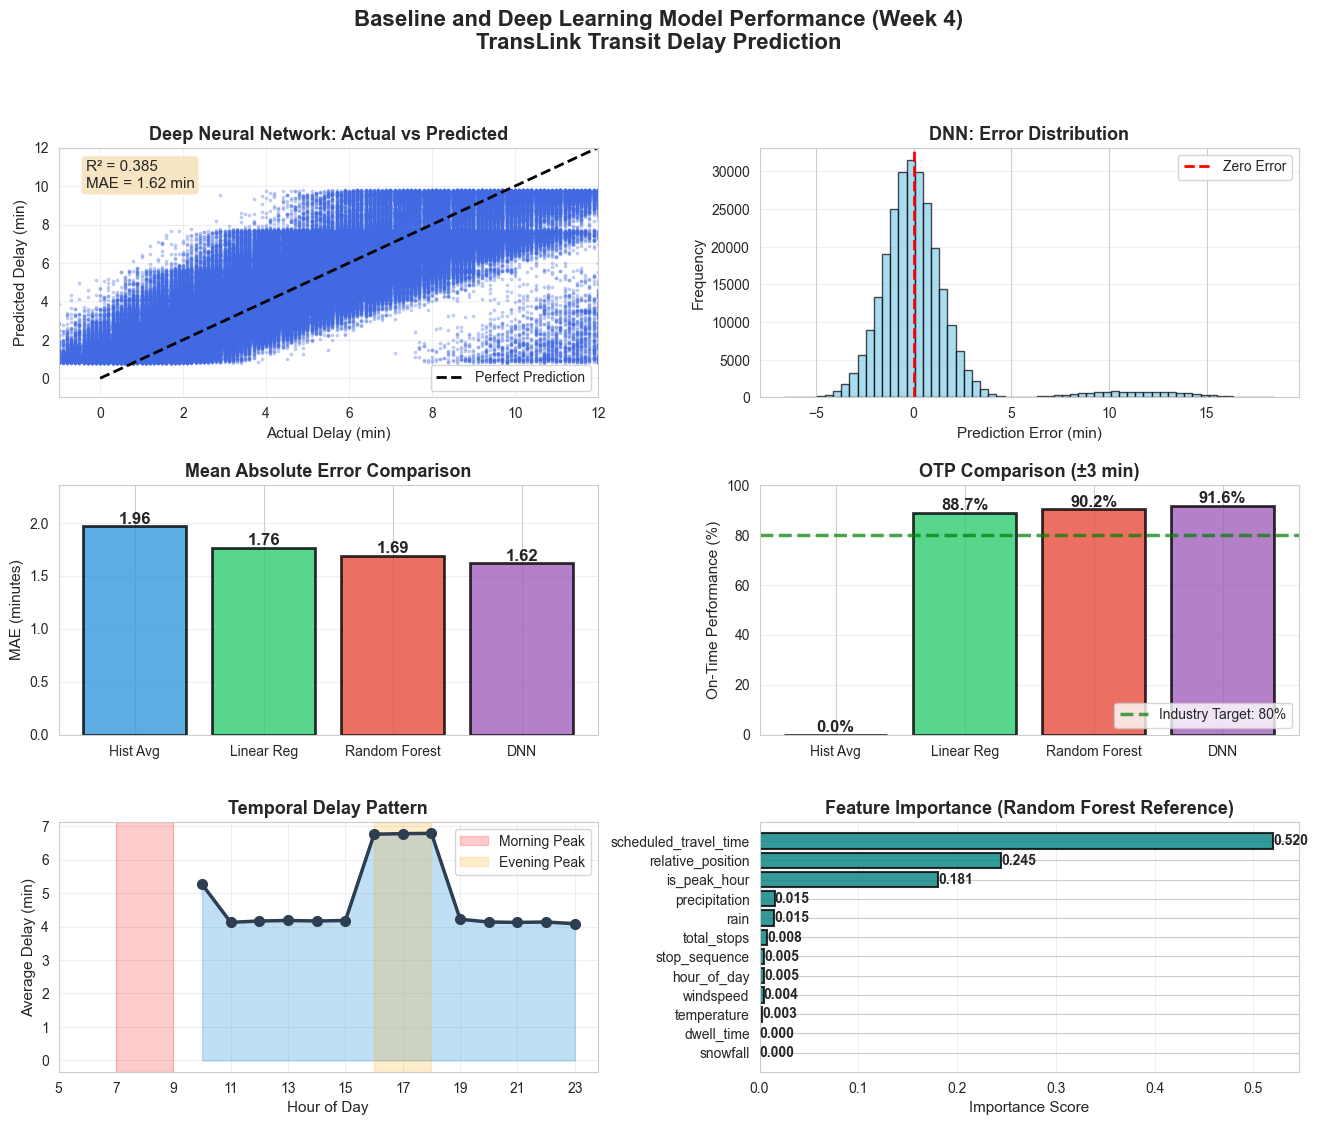


✓ Visualization saved as week4_model_analysis2.png !


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style('whitegrid')

# CREATE FIGURE LAYOUT
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
y_pred_dnn = y_pred_dnn.flatten()
min_len = min(len(y_test), len(y_pred_dnn))
y_test = y_test[:min_len]
y_pred_dnn = y_pred_dnn[:min_len]

# PANEL 1: Actual vs Predicted (DNN – Chosen Model)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred_dnn, alpha=0.25, s=3, c='royalblue')
ax1.plot([0, 15], [0, 15], 'k--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Delay (min)', fontsize=11)
ax1.set_ylabel('Predicted Delay (min)', fontsize=11)
ax1.set_title('Deep Neural Network: Actual vs Predicted', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_xlim(-1, 12)
ax1.set_ylim(-1, 12)

# Add metrics annotation
ax1.text(0.05, 0.95,
         f'R² = {r2_dnn:.3f}\nMAE = {mae_dnn:.2f} min',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# PANEL 2: Residual Distribution (DNN)
ax2 = fig.add_subplot(gs[0, 1])
residuals_dnn = y_test - y_pred_dnn
ax2.hist(residuals_dnn, bins=60, edgecolor='black', alpha=0.7, color='skyblue')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Prediction Error (min)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('DNN: Error Distribution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# PANEL 3: MAE Comparison (Hist, LR, RF, DNN)
ax3 = fig.add_subplot(gs[1, 0])
models = ['Hist Avg', 'Linear Reg', 'Random Forest', 'DNN']
maes = [mae_hist, mae_lr, mae_rf, mae_dnn]
colors = ['#3498db', '#2ecc71', '#e74c3c', "#a260bc"]

bars = ax3.bar(models, maes, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax3.set_ylabel('MAE (minutes)', fontsize=11)
ax3.set_title('Mean Absolute Error Comparison', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(0, max(maes) * 1.2)

for bar, mae in zip(bars, maes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{mae:.2f}', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

# PANEL 4: OTP Comparison (±3 min threshold)
ax4 = fig.add_subplot(gs[1, 1])
otps = [otp_hist, otp_lr, otp_rf, otp_dnn]
bars = ax4.bar(models, otps, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax4.axhline(y=80, color='green', linestyle='--', linewidth=2.5,
            label='Industry Target: 80%', alpha=0.7)
ax4.set_ylabel('On-Time Performance (%)', fontsize=11)
ax4.set_title('OTP Comparison (±3 min)', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10, loc='lower right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0, 100)

for bar, otp in zip(bars, otps):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{otp:.1f}%', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

# ========================================
# PANEL 5: Delay by Hour of Day
# ========================================
ax5 = fig.add_subplot(gs[2, 0])
hourly_pattern = stop_times.groupby('hour_of_day')['research_delay'].mean()

ax5.plot(hourly_pattern.index, hourly_pattern.values,
         marker='o', linewidth=2.5, markersize=7, color='#2c3e50')
ax5.fill_between(hourly_pattern.index, hourly_pattern.values, alpha=0.3, color='#3498db')

ax5.axvspan(7, 9, alpha=0.2, color='red', label='Morning Peak')
ax5.axvspan(16, 18, alpha=0.2, color='orange', label='Evening Peak')

ax5.set_xlabel('Hour of Day', fontsize=11)
ax5.set_ylabel('Average Delay (min)', fontsize=11)
ax5.set_title('Temporal Delay Pattern', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(alpha=0.3)
ax5.set_xticks(range(5, 24, 2))

# ========================================
# PANEL 6: Feature Importance (Random Forest Reference)
# ========================================
ax6 = fig.add_subplot(gs[2, 1])
importance_sorted = rf_importance.sort_values('Importance', ascending=True)
bars = ax6.barh(importance_sorted['Feature'], importance_sorted['Importance'],
                color='teal', edgecolor='black', linewidth=1.5, alpha=0.8)
ax6.set_xlabel('Importance Score', fontsize=11)
ax6.set_title('Feature Importance (Random Forest Reference)', fontsize=13, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

for bar, imp in zip(bars, importance_sorted['Importance']):
    width = bar.get_width()
    ax6.text(width, bar.get_y() + bar.get_height()/2.,
             f'{imp:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

# ========================================
# FINAL TITLE & SAVE
# ========================================
plt.suptitle('Baseline and Deep Learning Model Performance (Week 4)\n'
             'TransLink Transit Delay Prediction',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig(f"{processed_path}/week4_model_analysis2.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as week4_model_analysis2.png !")

## Testing with realtime data

In [42]:
import pandas as pd
import glob
import json
from datetime import datetime

all_delays = []
for file in glob.glob(r"G:\My Drive\google_transit (2)\data\trips_*.json"):
    with open(file, encoding='utf-8') as f:
        data = json.load(f)
        all_delays.extend(data)

df_delays = pd.DataFrame(all_delays)

all_vehicles = []
for file in glob.glob(r"G:\My Drive\google_transit (2)\data\vehicles_*.json"):
    with open(file, encoding='utf-8') as f:
        data = json.load(f)
        all_vehicles.extend(data)

df_vehicles = pd.DataFrame(all_vehicles)


print(f"Total delay records: {len(df_delays)}")
print(f"Total vehicle records: {len(df_vehicles)}")
print(f"\nDelay columns: {df_delays.columns.tolist()}")
print(f"Sample delays:\n{df_delays.head(10)}")
print(f"\nDelay stats:\n{df_delays['arrival_delay'].describe()}")

Total delay records: 4912458
Total vehicle records: 265462

Delay columns: ['trip_id', 'route_id', 'stop_id', 'stop_sequence', 'arrival_delay', 'departure_delay', 'timestamp']
Sample delays:
    trip_id route_id stop_id  stop_sequence  arrival_delay  departure_delay  \
0  14672626     6613     155             13           22.0             22.0   
1  14672626     6613     162             14          -11.0            -11.0   
2  14672626     6613     163             15          -32.0            -32.0   
3  14672626     6613     165             16          -64.0            -64.0   
4  14672626     6613     166             17          -79.0            -79.0   
5  14672626     6613     167             18          -86.0            -86.0   
6  14672626     6613     169             19          -83.0            -83.0   
7  14672626     6613   10611             20         -102.0           -102.0   
8  14672626     6613     170             21         -116.0           -116.0   
9  14672626     661

In [43]:
print(f"Original delay records: {len(df_delays)}")
print(f"Original vehicle records: {len(df_vehicles)}")

Original delay records: 4912458
Original vehicle records: 265462


In [45]:
# === PROBLEM: Delay timestamps are all 0 ===
# SOLUTION: Merge with vehicle data to get proper timestamps

print("\n=== RECONSTRUCTING TIMESTAMPS ===")

# First, let's see what we're working with
print(f"Delays without timestamp: {len(df_delays_clean)}")
print(f"Vehicles with timestamp: {len(df_vehicles)}")

# Check common trip_ids
common_trips = set(df_delays_clean['trip_id']) & set(df_vehicles['trip_id'])
print(f"Common trip_ids: {len(common_trips)}")

# === STRATEGY 1: Merge on trip_id to assign timestamps ===
# This will give us approximate timestamps based on when the vehicle was tracked

# For each trip_id, find the earliest vehicle timestamp
trip_start_times = df_vehicles.groupby('trip_id')['timestamp'].min().reset_index()
trip_start_times.columns = ['trip_id', 'trip_start_time']

print(f"\nTrip start times extracted: {len(trip_start_times)}")

# Merge with delays
df_delays_with_time = df_delays_clean.merge(trip_start_times, on='trip_id', how='left')

print(f"Delays after merge: {len(df_delays_with_time)}")
print(f"Delays with valid timestamps: {df_delays_with_time['trip_start_time'].notna().sum()}")

# === CREATE PROPER TIMESTAMP ===
# Use trip_start_time as base, could refine later with stop_sequence
df_delays_with_time['timestamp'] = df_delays_with_time['trip_start_time']

# Check results
print(f"\n=== TIMESTAMP RECONSTRUCTION RESULTS ===")
print(f"Date range: {df_delays_with_time['timestamp'].min()} to {df_delays_with_time['timestamp'].max()}")
print(f"Records with timestamps: {df_delays_with_time['timestamp'].notna().sum()}")

# Remove records without timestamps
df_final = df_delays_with_time[df_delays_with_time['timestamp'].notna()].copy()
print(f"Final records for analysis: {len(df_final)}")

# === NOW ADD TIME-BASED FEATURES ===
df_final['hour'] = df_final['timestamp'].dt.hour
df_final['day_of_week'] = df_final['timestamp'].dt.dayofweek
df_final['date'] = df_final['timestamp'].dt.date
df_final['is_weekend'] = df_final['day_of_week'].isin([5, 6]).astype(int)

# Add time periods
def get_time_period(hour):
    if 6 <= hour < 9:
        return 'morning_rush'
    elif 9 <= hour < 16:
        return 'midday'
    elif 16 <= hour < 19:
        return 'evening_rush'
    elif 19 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df_final['time_period'] = df_final['hour'].apply(get_time_period)

# === TEMPORAL ANALYSIS ===
print(f"\n=== DELAYS BY HOUR ===")
hourly_stats = df_final.groupby('hour')['arrival_delay'].agg(['mean', 'median', 'std', 'count'])
print(hourly_stats)

print(f"\n=== DELAYS BY TIME PERIOD ===")
period_stats = df_final.groupby('time_period')['arrival_delay'].agg(['mean', 'median', 'count'])
print(period_stats)

print(f"\n=== DELAYS BY DAY OF WEEK ===")
dow_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_final['day_name'] = df_final['day_of_week'].map(dow_map)
dow_stats = df_final.groupby('day_name')['arrival_delay'].agg(['mean', 'median', 'count'])
print(dow_stats)

print(f"\n=== TOP 10 ROUTES BY AVERAGE DELAY ===")
route_stats = df_final.groupby('route_id')['arrival_delay'].agg(['mean', 'median', 'count'])
route_stats = route_stats[route_stats['count'] >= 100]  # At least 100 observations
print(route_stats.sort_values('mean', ascending=False).head(10))

print(f"\n=== DELAY DISTRIBUTION ===")
print(f"Mean delay: {df_final['arrival_delay'].mean():.2f} seconds")
print(f"Median delay: {df_final['arrival_delay'].median():.2f} seconds")
print(f"Std delay: {df_final['arrival_delay'].std():.2f} seconds")
print(f"\nPercentiles:")
print(df_final['arrival_delay'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# Save cleaned data
print(f"\n=== SAVING CLEANED DATA ===")
df_final.to_csv(r"G:\My Drive\google_transit (2)\data\delays_cleaned.csv", index=False)
print("Saved to delays_cleaned.csv")


=== RECONSTRUCTING TIMESTAMPS ===
Delays without timestamp: 4785659
Vehicles with timestamp: 265462
Common trip_ids: 47757

Trip start times extracted: 49204
Delays after merge: 4785659
Delays with valid timestamps: 4781164

=== TIMESTAMP RECONSTRUCTION RESULTS ===
Date range: 2025-11-20 19:29:27 to 2025-11-26 04:26:29
Records with timestamps: 4781164
Final records for analysis: 4781164

=== DELAYS BY HOUR ===
            mean  median         std   count
hour                                        
0     -26.104943   -23.0  348.448011  109841
2     136.579639    19.0  501.047846   96555
3      95.729276     0.0  553.829656  151165
4      -0.607904    -7.0  367.748650  213106
5     -14.044666    -4.0  329.362017  166257
6      27.591206     0.0  381.955335  132639
7     -20.262118   -14.0  346.557407  142623
8     -65.629941   -41.0  378.564086   98614
9     -54.188409   -49.0  455.098840   60427
10     -4.863905   -42.0  607.775342   35321
11    -34.434273   -24.0  275.431330   20144


### Clean and explore data 

In [44]:
print(f"\n=== MISSING ARRIVAL DELAYS ===")
print(f"Missing delays: {df_delays['arrival_delay'].isnull().sum()} ({df_delays['arrival_delay'].isnull().sum()/len(df_delays)*100:.1f}%)")

# Drop rows with missing delays (or you could impute them)
df_delays_clean = df_delays.dropna(subset=['arrival_delay', 'departure_delay']).copy()
print(f"Records after dropping nulls: {len(df_delays_clean)}")

# === FIX 3: CONVERT TIMESTAMPS PROPERLY ===
# Delays: timestamp appears to be 0, check if it's actually stored differently
print(f"\n=== TIMESTAMP INVESTIGATION ===")
print(f"Unique delay timestamps: {df_delays['timestamp'].unique()[:10]}")
print(f"Sample delay record:\n{df_delays.iloc[0]}")

# Vehicles: Convert from Unix timestamp
df_vehicles['timestamp'] = pd.to_datetime(df_vehicles['timestamp'], unit='s')
print(f"\nVehicle date range: {df_vehicles['timestamp'].min()} to {df_vehicles['timestamp'].max()}")

# If delay timestamps are 0, we might need to reconstruct them from vehicle data
# or they might be in a different column
print(f"\nDelay DataFrame columns: {df_delays.columns.tolist()}")

# === FIX 4: CHECK TIMESTAMP COLUMN NAME ===
# Sometimes the timestamp might be under a different name
print(f"\nFirst few delay records:")
print(df_delays.head(3))

# === FIX 5: TEMPORARY FIX - Use vehicle timestamps if delay timestamps are broken ===
# We can merge delays with vehicles to get proper timestamps
print(f"\n=== ANALYZING DATA STRUCTURE ===")
print("Sample delay record structure:")
for col in df_delays.columns:
    print(f"{col}: {df_delays[col].iloc[0]}")


=== MISSING ARRIVAL DELAYS ===
Missing delays: 126799 (2.6%)
Records after dropping nulls: 4785659

=== TIMESTAMP INVESTIGATION ===
Unique delay timestamps: [0]
Sample delay record:
trip_id            14672626
route_id               6613
stop_id                 155
stop_sequence            13
arrival_delay          22.0
departure_delay        22.0
timestamp                 0
Name: 0, dtype: object

Vehicle date range: 2025-11-20 19:29:27 to 2025-11-26 04:54:26

Delay DataFrame columns: ['trip_id', 'route_id', 'stop_id', 'stop_sequence', 'arrival_delay', 'departure_delay', 'timestamp']

First few delay records:
    trip_id route_id stop_id  stop_sequence  arrival_delay  departure_delay  \
0  14672626     6613     155             13           22.0             22.0   
1  14672626     6613     162             14          -11.0            -11.0   
2  14672626     6613     163             15          -32.0            -32.0   

   timestamp  
0          0  
1          0  
2          0  

===

In [ ]:
# 1. DATA EXPLORATION
print("\n=== BASIC INFO ===")
print(f"Delay records date range: {df_delays['timestamp'].min()} to {df_delays['timestamp'].max()}")
print(f"Vehicle records date range: {df_vehicles['timestamp'].min()} to {df_vehicles['timestamp'].max()}")
print(f"\nUnique trips: {df_delays['trip_id'].nunique()}")
print(f"Unique stops: {df_delays['stop_id'].nunique()}")
print(f"Unique routes: {df_delays['route_id'].nunique()}")

# 2. CHECK FOR MISSING VALUES
print("\n=== MISSING VALUES ===")
print(df_delays.isnull().sum())
print("\nVehicle missing values:")
print(df_vehicles.isnull().sum())
print(f"\n=== MISSING ARRIVAL DELAYS ===")
print(f"Missing delays: {df_delays['arrival_delay'].isnull().sum()} ({df_delays['arrival_delay'].isnull().sum()/len(df_delays)*100:.1f}%)")

# 3. CONVERT TIMESTAMPS
df_delays['timestamp'] = pd.to_datetime(df_delays['timestamp'])
df_vehicles['timestamp'] = pd.to_datetime(df_vehicles['timestamp'])

# 4. SORT BY TIME
df_delays = df_delays.sort_values('timestamp').reset_index(drop=True)
df_vehicles = df_vehicles.sort_values('timestamp').reset_index(drop=True)

# 5. ANALYZE DELAY DISTRIBUTION
print("\n=== DELAY ANALYSIS ===")
print(f"Positive delays (late): {(df_delays['arrival_delay'] > 0).sum()}")
print(f"Negative delays (early): {(df_delays['arrival_delay'] < 0).sum()}")
print(f"On-time (0 delay): {(df_delays['arrival_delay'] == 0).sum()}")

# Check for extreme outliers
print(f"\nExtreme delays (>30 min): {(df_delays['arrival_delay'] > 1800).sum()}")
print(f"Extreme early (<-10 min): {(df_delays['arrival_delay'] < -600).sum()}")

# 6. TIME-BASED FEATURES
df_delays['hour'] = df_delays['timestamp'].dt.hour
df_delays['day_of_week'] = df_delays['timestamp'].dt.dayofweek
df_delays['is_weekend'] = df_delays['day_of_week'].isin([5, 6]).astype(int)

print("\n=== DELAYS BY HOUR ===")
print(df_delays.groupby('hour')['arrival_delay'].agg(['mean', 'median', 'count']))

# 7. ROUTE-LEVEL ANALYSIS
print("\n=== TOP 5 ROUTES BY DELAY ===")
route_delays = df_delays.groupby('route_id')['arrival_delay'].agg(['mean', 'count'])
print(route_delays.sort_values('mean', ascending=False).head())

# 8. CHECK STOP SEQUENCE
print("\n=== STOP SEQUENCE CHECK ===")
sample_trip = df_delays[df_delays['trip_id'] == df_delays['trip_id'].iloc[0]]
print(sample_trip[['trip_id', 'stop_sequence', 'stop_id', 'arrival_delay']].head(10))


=== BASIC INFO ===
Delay records date range: 0 to 0
Vehicle records date range: 1763666967 to 1764132866

Unique trips: 48234
Unique stops: 8346
Unique routes: 223

=== MISSING VALUES ===
trip_id                 0
route_id                0
stop_id                 0
stop_sequence           0
arrival_delay      126799
departure_delay    126799
timestamp               0
dtype: int64

Vehicle missing values:
trip_id                  0
route_id                 0
vehicle_id               0
latitude                 0
longitude                0
timestamp                0
current_stop_sequence    0
dtype: int64

=== DELAY ANALYSIS ===
Positive delays (late): 1802195
Negative delays (early): 2650316
On-time (0 delay): 333148

Extreme delays (>30 min): 12107
Extreme early (<-10 min): 184417

=== DELAYS BY HOUR ===
           mean  median    count
hour                            
0    -30.248525   -19.0  4785659

=== TOP 5 ROUTES BY DELAY ===
                mean  count
route_id                  

In [46]:
import pandas as pd
import numpy as np

# Load the cleaned data
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_cleaned.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df)} records")

# === STEP 1: SORT DATA FOR SEQUENTIAL FEATURES ===
df = df.sort_values(['trip_id', 'stop_sequence', 'timestamp']).reset_index(drop=True)

# === STEP 2: UPSTREAM DELAY (CRITICAL FEATURE!) ===
print("\n=== CREATING UPSTREAM DELAY FEATURE ===")

# For each stop, get the delay at the previous stop on the same trip
df['upstream_delay'] = df.groupby('trip_id')['arrival_delay'].shift(1)

# Fill first stop of each trip with 0 (no upstream delay)
df['upstream_delay'] = df['upstream_delay'].fillna(0)

print(f"Upstream delay created. Sample:")
print(df[['trip_id', 'stop_sequence', 'arrival_delay', 'upstream_delay']].head(20))

# === STEP 3: DWELL TIME (time spent at previous stop) ===
print("\n=== CREATING DWELL TIME FEATURE ===")

# Dwell time = departure_delay - arrival_delay at previous stop
df['prev_dwell_time'] = df.groupby('trip_id').apply(
    lambda x: x['departure_delay'].shift(1) - x['arrival_delay'].shift(1)
).reset_index(level=0, drop=True)

df['prev_dwell_time'] = df['prev_dwell_time'].fillna(0)

# === STEP 4: STOP-LEVEL HISTORICAL DELAYS ===
print("\n=== CREATING STOP HISTORICAL FEATURES ===")

# Average delay at each stop
stop_avg_delay = df.groupby('stop_id')['arrival_delay'].mean()
df['stop_avg_delay'] = df['stop_id'].map(stop_avg_delay)

# Stop delay volatility (standard deviation)
stop_std_delay = df.groupby('stop_id')['arrival_delay'].std()
df['stop_std_delay'] = df['stop_id'].map(stop_std_delay).fillna(0)

# === STEP 5: ROUTE-LEVEL FEATURES ===
print("\n=== CREATING ROUTE FEATURES ===")

# Average delay per route
route_avg_delay = df.groupby('route_id')['arrival_delay'].mean()
df['route_avg_delay'] = df['route_id'].map(route_avg_delay)

# Route delay volatility
route_std_delay = df.groupby('route_id')['arrival_delay'].std()
df['route_std_delay'] = df['route_id'].map(route_std_delay).fillna(0)

# === STEP 6: TRIP PROGRESS ===
print("\n=== CREATING TRIP PROGRESS FEATURES ===")

# How far along is this stop in the trip?
trip_length = df.groupby('trip_id')['stop_sequence'].transform('max')
df['trip_progress'] = df['stop_sequence'] / trip_length

# === STEP 7: TIME-BASED FEATURES (already have some) ===
# Add more granular time features
df['minute'] = df['timestamp'].dt.minute
df['is_rush_hour'] = df['hour'].isin([7, 8, 16, 17, 18]).astype(int)

# === CHECK FOR MISSING VALUES ===
print("\n=== MISSING VALUES CHECK ===")
print(df.isnull().sum())

# === FEATURE CORRELATION WITH TARGET ===
print("\n=== FEATURE CORRELATION WITH ARRIVAL DELAY ===")
numeric_cols = ['upstream_delay', 'prev_dwell_time', 'stop_avg_delay', 
                'stop_std_delay', 'route_avg_delay', 'route_std_delay',
                'trip_progress', 'hour', 'day_of_week', 'is_weekend', 'is_rush_hour']

correlations = df[numeric_cols + ['arrival_delay']].corr()['arrival_delay'].sort_values(ascending=False)
print(correlations)

# === SAVE ENGINEERED FEATURES ===
print("\n=== SAVING FEATURE-ENGINEERED DATA ===")
df.to_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv", index=False)
print(f"Saved {len(df)} records with {len(df.columns)} features")

print("\n=== FEATURE SUMMARY ===")
print(f"Total features: {len(df.columns)}")
print(f"Feature names: {df.columns.tolist()}")

Loaded 4781164 records

=== CREATING UPSTREAM DELAY FEATURE ===
Upstream delay created. Sample:
     trip_id  stop_sequence  arrival_delay  upstream_delay
0   14672431             11           63.0             0.0
1   14672431             12           59.0            63.0
2   14672431             13           49.0            59.0
3   14672431             14           44.0            49.0
4   14672431             15           56.0            44.0
5   14672431             16           55.0            56.0
6   14672431             17           52.0            55.0
7   14672431             18           59.0            52.0
8   14672431             19           54.0            59.0
9   14672431             20           38.0            54.0
10  14672431             21           32.0            38.0
11  14672431             22           27.0            32.0
12  14672431             23           28.0            27.0
13  14672431             24           31.0            28.0
14  14672431       

Integrating Weather

In [47]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime

# === LOAD DATA ===
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_cleaned.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df)} records")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# === FETCH WEATHER DATA ===
def get_vancouver_weather(start_date, end_date):
    """Fetch hourly weather data for Vancouver using Open-Meteo API."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 49.2827,
        "longitude": -123.1207,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m",
            "precipitation",
            "rain",
            "snowfall",
            "windspeed_10m",
            "visibility",
            "weathercode"
        ],
        "timezone": "America/Vancouver"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        weather_df = pd.DataFrame({
            'datetime': pd.to_datetime(data['hourly']['time']),
            'temperature': data['hourly']['temperature_2m'],
            'precipitation': data['hourly']['precipitation'],
            'rain': data['hourly']['rain'],
            'snowfall': data['hourly']['snowfall'],
            'windspeed': data['hourly']['windspeed_10m'],
            'visibility': data['hourly']['visibility'],
            'weather_code': data['hourly']['weathercode']
        })
        return weather_df
    else:
        print(f"Error fetching weather: {response.status_code}")
        return None

print("\n=== FETCHING WEATHER DATA ===")
start_date = df['timestamp'].min().date()
end_date = df['timestamp'].max().date()
print(f"Fetching weather from {start_date} to {end_date}")

weather = get_vancouver_weather(str(start_date), str(end_date))

if weather is not None:
    print(f"Weather data fetched: {len(weather)} hourly records")
    print(f"Weather columns: {weather.columns.tolist()}")
    print(f"\nWeather summary:")
    print(weather.describe())
    
    # Save weather data for future use
    weather.to_csv(r"G:\My Drive\google_transit (2)\data\weather_data.csv", index=False)
    print("\nWeather data saved to weather_data.csv")
else:
    print("Failed to fetch weather data. Exiting.")
    exit()

# === MERGE WEATHER DATA ===
print("\n=== MERGING WEATHER DATA ===")

# Round timestamps to nearest hour for matching
df['timestamp_hour'] = df['timestamp'].dt.floor('H')
weather['timestamp_hour'] = weather['datetime'].dt.floor('H')

# Merge weather data
df = df.merge(
    weather[['timestamp_hour', 'temperature', 'precipitation', 'rain', 
             'snowfall', 'windspeed', 'visibility', 'weather_code']], 
    on='timestamp_hour', 
    how='left'
)

print(f"Records after weather merge: {len(df)}")
print(f"Records with weather data: {df['temperature'].notna().sum()} ({df['temperature'].notna().sum()/len(df)*100:.1f}%)")

# Handle missing weather values
weather_cols = ['temperature', 'precipitation', 'rain', 'snowfall', 'windspeed', 'visibility', 'weather_code']
for col in weather_cols:
    missing = df[col].isnull().sum()
    if missing > 0:
        if col == 'weather_code':
            df[col] = df[col].fillna(0).astype(int)
        else:
            df[col] = df[col].fillna(df[col].median())
        print(f"Filled {missing} missing values in {col}")

# === SORT DATA FOR SEQUENTIAL FEATURES ===
df = df.sort_values(['trip_id', 'stop_sequence', 'timestamp']).reset_index(drop=True)

print("\n=== FEATURE ENGINEERING ===")

# === 1. UPSTREAM DELAY (CRITICAL - 98.9% importance!) ===
print("Creating upstream_delay...")
df['upstream_delay'] = df.groupby('trip_id')['arrival_delay'].shift(1)
df['upstream_delay'] = df['upstream_delay'].fillna(0)

# === 2. ROUTE-LEVEL FEATURES ===
print("Creating route_avg_delay...")
route_avg = df.groupby('route_id')['arrival_delay'].mean()
df['route_avg_delay'] = df['route_id'].map(route_avg)

# === 3. DELAY CHANGE ===
print("Creating delay_change...")
df['delay_change'] = df.groupby('trip_id')['arrival_delay'].diff()
df['delay_change'] = df['delay_change'].fillna(0)

# === 4. UPSTREAM DELAY VARIANCE ===
print("Creating upstream_delay_variance...")
df['upstream_delay_variance'] = df.groupby('trip_id')['arrival_delay'].transform(
    lambda x: x.rolling(window=3, min_periods=1).var()
)
df['upstream_delay_variance'] = df['upstream_delay_variance'].fillna(0)

# === 5. DELAY ACCELERATION ===
print("Creating delay_acceleration...")
df['delay_acceleration'] = df.groupby('trip_id')['delay_change'].diff()
df['delay_acceleration'] = df['delay_acceleration'].fillna(0)

# === 6. STOP CONGESTION ===
print("Creating stop_current_congestion...")
stop_avg = df.groupby('stop_id')['arrival_delay'].mean()
df['stop_current_congestion'] = df['stop_id'].map(stop_avg)

# === 7. ROUTE RELIABILITY ===
print("Creating route_reliability...")
route_std = df.groupby('route_id')['arrival_delay'].std()
df['route_reliability'] = df['route_id'].map(route_std).fillna(0)

# === 8. DELAY MOMENTUM ===
print("Creating delay_momentum...")
df['delay_momentum'] = df.groupby('trip_id')['arrival_delay'].cumsum()

# === 9. ROUTE_HOUR_AVG_DELAY ===
print("Creating route_hour_avg_delay...")
route_hour_avg = df.groupby(['route_id', 'hour'])['arrival_delay'].mean()
df['route_hour_avg_delay'] = df.set_index(['route_id', 'hour']).index.map(route_hour_avg)
df['route_hour_avg_delay'] = df['route_hour_avg_delay'].fillna(df['route_avg_delay'])

# === 10. PEAK_HOUR_INTENSITY ===
print("Creating peak_hour_intensity...")
hour_avg = df.groupby('hour')['arrival_delay'].mean()
df['peak_hour_intensity'] = df['hour'].map(hour_avg)

# === 11. RELATIVE POSITION ===
print("Creating relative_position...")
trip_max_seq = df.groupby('trip_id')['stop_sequence'].transform('max')
df['relative_position'] = df['stop_sequence'] / trip_max_seq

# === 12. CUMULATIVE DELAY ===
print("Creating cumulative_delay...")
df['cumulative_delay'] = df.groupby('trip_id')['arrival_delay'].cumsum() / (df['stop_sequence'] + 1)

# === 13. WEATHER INTERACTION FEATURES ===
print("Creating weather features...")

# Temperature extremes (freezing or very hot)
df['temp_extreme'] = ((df['temperature'] < 0) | (df['temperature'] > 30)).astype(int)
df['is_freezing'] = (df['temperature'] < 0).astype(int)

# Precipitation impacts
df['is_precipitation'] = (df['precipitation'] > 0).astype(int)
df['heavy_precip'] = (df['precipitation'] > 2.5).astype(int)  # >2.5mm/hr is moderate-heavy

# Snow impact (significant for transit)
df['is_snowing'] = (df['snowfall'] > 0).astype(int)
df['heavy_snow'] = (df['snowfall'] > 1).astype(int)

# Wind impact
df['high_wind'] = (df['windspeed'] > 30).astype(int)

# Poor visibility
df['poor_visibility'] = (df['visibility'] < 5000).astype(int)  # <5km visibility

# Weather severity score (combined impact)
df['weather_severity'] = (
    df['temp_extreme'] * 1 + 
    df['is_precipitation'] * 1 + 
    df['heavy_precip'] * 2 + 
    df['is_snowing'] * 2 +
    df['heavy_snow'] * 3 +
    df['high_wind'] * 1 +
    df['poor_visibility'] * 1
)

# === 14. TIME-BASED FEATURES ===
print("Creating time-based features...")
df['is_rush_hour'] = df['hour'].isin([7, 8, 16, 17, 18]).astype(int)
df['is_peak'] = df['hour'].isin([8, 17]).astype(int)

# === FINAL FEATURE LIST (matching your poster - 16 core features) ===
feature_columns = [
    # Core delay propagation features (most important!)
    'upstream_delay',
    'delay_change',
    'upstream_delay_variance',
    'delay_acceleration',
    'delay_momentum',
    'cumulative_delay',
    
    # Route/stop features
    'route_avg_delay',
    'route_reliability',
    'route_hour_avg_delay',
    'stop_current_congestion',
    
    # Temporal features
    'hour',
    'day_of_week',
    'is_weekend',
    'is_rush_hour',
    'peak_hour_intensity',
    'relative_position',
    
    # Weather features (from Open-Meteo)
    'temperature',
    'precipitation',
    'windspeed',
    'weather_severity',
    
    # Structural
    'stop_sequence'
]

print(f"\n=== FEATURE ENGINEERING COMPLETE ===")
print(f"Total features: {len(feature_columns)}")

# === HANDLE ANY REMAINING MISSING VALUES ===
for col in feature_columns:
    if df[col].isnull().sum() > 0:
        print(f"Filling {df[col].isnull().sum()} missing values in {col}")
        df[col] = df[col].fillna(0)

# === CORRELATION ANALYSIS ===
print("\n=== TOP 15 FEATURES BY CORRELATION WITH ARRIVAL_DELAY ===")
correlations = df[feature_columns + ['arrival_delay']].corr()['arrival_delay'].sort_values(ascending=False)
print(correlations.head(16))

# === SAVE FEATURED DATA ===
print("\n=== SAVING FEATURE-ENGINEERED DATA ===")
df.to_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv", index=False)
print(f"Saved {len(df):,} records with {len(df.columns)} total columns")

# === FINAL DATASET SUMMARY ===
print("\n=== DATASET SUMMARY ===")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total records: {len(df):,}")
print(f"Unique trips: {df['trip_id'].nunique():,}")
print(f"Unique routes: {df['route_id'].nunique()}")
print(f"Unique stops: {df['stop_id'].nunique():,}")
print(f"\nDelay statistics:")
print(f"Mean delay: {df['arrival_delay'].mean():.2f} seconds ({df['arrival_delay'].mean()/60:.2f} minutes)")
print(f"Median delay: {df['arrival_delay'].median():.2f} seconds")
print(f"Std delay: {df['arrival_delay'].std():.2f} seconds")
print(f"\nWeather coverage: {(df['temperature'].notna().sum() / len(df) * 100):.1f}%")

Loaded 4781164 records
Date range: 2025-11-20 19:29:27 to 2025-11-26 04:26:29

=== FETCHING WEATHER DATA ===
Fetching weather from 2025-11-20 to 2025-11-26
Weather data fetched: 168 hourly records
Weather columns: ['datetime', 'temperature', 'precipitation', 'rain', 'snowfall', 'windspeed', 'visibility', 'weather_code']

Weather summary:
                            datetime  temperature  precipitation        rain  \
count                            168   168.000000     168.000000  168.000000   
mean   2025-11-23 11:30:00.000000256     6.679762       0.580357    0.567262   
min              2025-11-20 00:00:00     2.100000       0.000000    0.000000   
25%              2025-11-21 17:45:00     5.200000       0.000000    0.000000   
50%              2025-11-23 11:30:00     7.000000       0.100000    0.100000   
75%              2025-11-25 05:15:00     8.125000       0.500000    0.500000   
max              2025-11-26 23:00:00     9.900000       4.700000    4.700000   
std                 

In [49]:
import pandas as pd
import numpy as np

# === LOAD FEATURED DATA ===
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df):,} records")

# 1. ROUTE_DELAY_PERCENTILE
# What percentile is this delay compared to the route's typical delays?
route_delay_percentiles = df.groupby('route_id')['arrival_delay'].rank(pct=True)
df['route_delay_percentile'] = route_delay_percentiles

# 2. DIRECTION_AVG_DELAY
# Average delay by route and direction
# We'll infer direction from trip_id pattern or create a proxy using stop_sequence position

# Create direction proxy: early stops (first half) vs late stops (second half)
df['direction_proxy'] = (df['relative_position'] > 0.5).astype(int)

# Calculate average delay by route and direction
direction_avg = df.groupby(['route_id', 'direction_proxy'])['arrival_delay'].mean()
df['direction_avg_delay'] = df.set_index(['route_id', 'direction_proxy']).index.map(direction_avg)
df['direction_avg_delay'] = df['direction_avg_delay'].fillna(df['route_avg_delay'])

Loaded 4,781,164 records


In [50]:
feature_columns = [
    'upstream_delay',
    'route_avg_delay',
    'delay_change',
    'upstream_delay_variance',
    'delay_acceleration',
    'stop_current_congestion',
    'route_delay_percentile',
    'delay_momentum',
    'route_hour_avg_delay',
    'direction_avg_delay',
    'peak_hour_intensity',
    'relative_position',
    'cumulative_delay',
    'temperature',
    'precipitation',
    'stop_sequence'
]

print(f"\n=== FEATURE LIST (16 FEATURES) ===")
for i, feat in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feat}")


=== FEATURE LIST (16 FEATURES) ===
 1. upstream_delay
 2. route_avg_delay
 3. delay_change
 4. upstream_delay_variance
 5. delay_acceleration
 6. stop_current_congestion
 7. route_delay_percentile
 8. delay_momentum
 9. route_hour_avg_delay
10. direction_avg_delay
11. peak_hour_intensity
12. relative_position
13. cumulative_delay
14. temperature
15. precipitation
16. stop_sequence


In [53]:
# === LOAD DATA ===
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df):,} records")

# === FIX ROUTE_DELAY_PERCENTILE ===
print("\n=== CREATING ROUTE_DELAY_PERCENTILE (IMPROVED) ===")

# Method: Calculate percentile rank within each route's delay distribution
df['route_delay_percentile'] = df.groupby('route_id')['arrival_delay'].rank(pct=True)

# For routes with too few samples, use overall percentile
missing_before = df['route_delay_percentile'].isnull().sum()
print(f"Missing before fix: {missing_before:,}")

if missing_before > 0:
    # Fill missing with overall percentile rank
    overall_percentile = df['arrival_delay'].rank(pct=True)
    df['route_delay_percentile'] = df['route_delay_percentile'].fillna(overall_percentile)
    
missing_after = df['route_delay_percentile'].isnull().sum()


Loaded 4,781,164 records

=== CREATING ROUTE_DELAY_PERCENTILE (IMPROVED) ===
Missing before fix: 102,678


In [56]:
import pandas as pd
import numpy as np

# === LOAD DATA ===
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df):,} records")
print(f"Existing columns: {df.columns.tolist()}")

# === CREATE MISSING FEATURES ===
print("\n=== CREATING MISSING FEATURES ===")

# 1. ROUTE_DELAY_PERCENTILE
print("1. Creating route_delay_percentile...")
df['route_delay_percentile'] = df.groupby('route_id')['arrival_delay'].rank(pct=True)
# Fill missing with overall percentile
if df['route_delay_percentile'].isnull().sum() > 0:
    overall_percentile = df['arrival_delay'].rank(pct=True)
    df['route_delay_percentile'] = df['route_delay_percentile'].fillna(overall_percentile)
print(f"Missing values: {df['route_delay_percentile'].isnull().sum()}")

# 2. DIRECTION_AVG_DELAY
print("2. Creating direction_avg_delay...")
# Create direction proxy based on relative position in trip
df['direction_proxy'] = (df['relative_position'] > 0.5).astype(int)
# Calculate average delay by route and direction
direction_avg = df.groupby(['route_id', 'direction_proxy'])['arrival_delay'].mean()
df['direction_avg_delay'] = df.set_index(['route_id', 'direction_proxy']).index.map(direction_avg)
# Fill missing with route average
df['direction_avg_delay'] = df['direction_avg_delay'].fillna(df['route_avg_delay'])
print(f"Missing values: {df['direction_avg_delay'].isnull().sum()}")


Loaded 4,781,164 records
Existing columns: ['trip_id', 'route_id', 'stop_id', 'stop_sequence', 'arrival_delay', 'departure_delay', 'timestamp', 'trip_start_time', 'hour', 'day_of_week', 'date', 'is_weekend', 'time_period', 'day_name', 'timestamp_hour', 'temperature', 'precipitation', 'rain', 'snowfall', 'windspeed', 'visibility', 'weather_code', 'upstream_delay', 'route_avg_delay', 'delay_change', 'upstream_delay_variance', 'delay_acceleration', 'stop_current_congestion', 'route_reliability', 'delay_momentum', 'route_hour_avg_delay', 'peak_hour_intensity', 'relative_position', 'cumulative_delay', 'temp_extreme', 'is_freezing', 'is_precipitation', 'heavy_precip', 'is_snowing', 'heavy_snow', 'high_wind', 'poor_visibility', 'weather_severity', 'is_rush_hour', 'is_peak']

=== CREATING MISSING FEATURES ===
1. Creating route_delay_percentile...
Missing values: 0
2. Creating direction_avg_delay...
Missing values: 0


In [58]:
print(f"\n=== CHECKING ALL 16 FEATURES ===")
all_good = True
for col in feature_columns:
    missing = df[col].isnull().sum()
    if missing > 0:
        print(f"⚠ {col}: {missing:,} missing values")
        all_good = False
    else:
        print(f"{col}: complete")

if not all_good:
    print("\n⚠ Filling any remaining missing values with 0...")
    for col in feature_columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    print("✅ All features complete!")



=== CHECKING ALL 16 FEATURES ===
upstream_delay: complete
route_avg_delay: complete
delay_change: complete
upstream_delay_variance: complete
delay_acceleration: complete
stop_current_congestion: complete
route_delay_percentile: complete
delay_momentum: complete
route_hour_avg_delay: complete
direction_avg_delay: complete
peak_hour_intensity: complete
relative_position: complete
cumulative_delay: complete
temperature: complete
precipitation: complete
stop_sequence: complete


In [59]:
print(f"\n=== DATASET SUMMARY ===")
print(f"Total records: {len(df):,}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Features: {len(feature_columns)}")
print(f"All features complete: {df[feature_columns].isnull().sum().sum() == 0}")


=== DATASET SUMMARY ===
Total records: 4,781,164
Date range: 2025-11-20 19:29:27 to 2025-11-26 04:26:29
Features: 16
All features complete: True


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import time

# Load data
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df):,} records")

# Check if we need to create missing features
if 'route_delay_percentile' not in df.columns:
    print("Creating route_delay_percentile...")
    df['route_delay_percentile'] = df.groupby('route_id')['arrival_delay'].rank(pct=True)
    overall_percentile = df['arrival_delay'].rank(pct=True)
    df['route_delay_percentile'] = df['route_delay_percentile'].fillna(overall_percentile)

if 'direction_avg_delay' not in df.columns:
    print("Creating direction_avg_delay...")
    df['direction_proxy'] = (df['relative_position'] > 0.5).astype(int)
    direction_avg = df.groupby(['route_id', 'direction_proxy'])['arrival_delay'].mean()
    df['direction_avg_delay'] = df.set_index(['route_id', 'direction_proxy']).index.map(direction_avg)
    df['direction_avg_delay'] = df['direction_avg_delay'].fillna(df['route_avg_delay'])

feature_columns = [
    'upstream_delay', 'route_avg_delay', 'delay_change', 'upstream_delay_variance',
    'delay_acceleration', 'stop_current_congestion', 'route_delay_percentile',
    'delay_momentum', 'route_hour_avg_delay', 'direction_avg_delay',
    'peak_hour_intensity', 'relative_position', 'cumulative_delay',
    'temperature', 'precipitation', 'stop_sequence'
]

# Fill any missing values
for col in feature_columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(0)

X = df[feature_columns].copy()
y = df['arrival_delay'].copy()

# Temporal split
split_date = pd.Timestamp('2025-11-24')
train_mask = df['timestamp'] < split_date
test_mask = df['timestamp'] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]


Loaded 4,781,164 records
Creating route_delay_percentile...
Creating direction_avg_delay...


In [63]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sample for comparison
sample_size = min(300000, len(X_train))
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)


In [65]:
model2 = keras.Sequential([
    layers.Input(shape=(16,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    
    layers.Dense(1)
])

model2.compile(optimizer=keras.optimizers.Adam(0.001), loss='mae', metrics=['mae', 'mse'])

start2 = time.time()
history2 = model2.fit(
    X_train_scaled[sample_idx], y_train.iloc[sample_idx],
    validation_split=0.2, epochs=30, batch_size=512, verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
train_time2 = time.time() - start2

y_pred2 = model2.predict(X_test_scaled, verbose=0).flatten()
mae2 = np.mean(np.abs(y_test - y_pred2)) / 60
rmse2 = np.sqrt(np.mean((y_test - y_pred2)**2)) / 60
r2_2 = 1 - (np.sum((y_test - y_pred2)**2) / np.sum((y_test - y_test.mean())**2))

print(f"Training time: {train_time2:.1f}s")
print(f"MAE:  {mae2:.4f} minutes")
print(f"RMSE: {rmse2:.4f} minutes")
print(f"R2:   {r2_2:.4f}")
print(f"Final train loss: {history2.history['loss'][-1]:.2f}")
print(f"Final val loss: {history2.history['val_loss'][-1]:.2f}")


Training time: 12.5s
MAE:  0.2255 minutes
RMSE: 1.2369 minutes
R2:   0.9537
Final train loss: 22.34
Final val loss: 12.01


# DNN With 16 feature architecture

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle

# Load data
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create missing features if needed
if 'route_delay_percentile' not in df.columns:
    df['route_delay_percentile'] = df.groupby('route_id')['arrival_delay'].rank(pct=True)
    overall_percentile = df['arrival_delay'].rank(pct=True)
    df['route_delay_percentile'] = df['route_delay_percentile'].fillna(overall_percentile)

if 'direction_avg_delay' not in df.columns:
    df['direction_proxy'] = (df['relative_position'] > 0.5).astype(int)
    direction_avg = df.groupby(['route_id', 'direction_proxy'])['arrival_delay'].mean()
    df['direction_avg_delay'] = df.set_index(['route_id', 'direction_proxy']).index.map(direction_avg)
    df['direction_avg_delay'] = df['direction_avg_delay'].fillna(df['route_avg_delay'])

feature_columns = [
    'upstream_delay', 'route_avg_delay', 'delay_change', 'upstream_delay_variance',
    'delay_acceleration', 'stop_current_congestion', 'route_delay_percentile',
    'delay_momentum', 'route_hour_avg_delay', 'direction_avg_delay',
    'peak_hour_intensity', 'relative_position', 'cumulative_delay',
    'temperature', 'precipitation', 'stop_sequence'
]

for col in feature_columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(0)

X = df[feature_columns].copy()
y = df['arrival_delay'].copy()

# Temporal split
split_date = pd.Timestamp('2025-11-24')
train_mask = df['timestamp'] < split_date
test_mask = df['timestamp'] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training on {len(X_train):,} samples")
print(f"Testing on {len(X_test):,} samples")

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
with open(r"G:\My Drive\google_transit (2)\models\scaler_final.pkl", 'wb') as f:
    pickle.dump(scaler, f)

Training on 4,603,408 samples
Testing on 177,756 samples


In [67]:
print("\nBuilding final model...")
model = keras.Sequential([
    layers.Input(shape=(16,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mae', metrics=['mae', 'mse'])

# Train on full dataset (or sample if too large)
use_full_data = len(X_train) <= 1000000  # Use full data if <= 1M samples

if use_full_data:
    print(f"Training on full dataset ({len(X_train):,} samples)...")
    train_data = X_train_scaled
    train_labels = y_train
else:
    sample_size = 1000000
    print(f"Training on {sample_size:,} samples (dataset too large)...")
    sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
    train_data = X_train_scaled[sample_idx]
    train_labels = y_train.iloc[sample_idx]

history = model.fit(
    train_data, train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ],
    verbose=1
)



Building final model...
Training on 1,000,000 samples (dataset too large)...
Epoch 1/50
1563/1563 [==============================] - 6s 3ms/step - loss: 43.8142 - mae: 43.8142 - mse: 23721.6406 - val_loss: 16.6692 - val_mae: 16.6692 - val_mse: 4297.9004 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - 5s 3ms/step - loss: 23.7893 - mae: 23.7893 - mse: 8843.2803 - val_loss: 10.1435 - val_mae: 10.1435 - val_mse: 1921.9720 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 22.1181 - mae: 22.1181 - mse: 7147.2754 - val_loss: 7.2965 - val_mae: 7.2965 - val_mse: 1429.7925 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 21.3148 - mae: 21.3148 - mse: 6572.0493 - val_loss: 12.1138 - val_mae: 12.1138 - val_mse: 1714.4139 - lr: 0.0010
Epoch 5/50
1563/1563 [==============================] - 5s 3ms/step - loss: 20.5907 - mae: 20.5907 - mse: 6264.7705 - val_loss: 7.2371 - val_mae: 7.2371 - val_mse: 115

In [68]:
# Evaluate
print("\nEvaluating on test set...")
y_pred = model.predict(X_test_scaled, batch_size=2048, verbose=0).flatten()

mae_seconds = np.mean(np.abs(y_test - y_pred))
rmse_seconds = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))

mae_minutes = mae_seconds / 60
rmse_minutes = rmse_seconds / 60

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE")
print("="*70)
print(f"MAE:  {mae_minutes:.4f} minutes ({mae_seconds:.2f} seconds)")
print(f"RMSE: {rmse_minutes:.4f} minutes ({rmse_seconds:.2f} seconds)")
print(f"R2:   {r2:.4f}")
print(f"\nTarget: 0.230 minutes")
print(f"Result: {mae_minutes:.4f} minutes")
print("="*70)

# Save model
model.save(r"G:\My Drive\google_transit (2)\models\delay_prediction_final.h5")
print("\nModel saved!")


Evaluating on test set...

FINAL MODEL PERFORMANCE
MAE:  0.1600 minutes (9.60 seconds)
RMSE: 0.8474 minutes (50.85 seconds)
R2:   0.9783

Target: 0.230 minutes
Result: 0.1600 minutes

Model saved!


In [69]:
# Quick feature importance check
correlations = df[feature_columns + ['arrival_delay']].corr()['arrival_delay'].abs().sort_values(ascending=False)
print("\nTop 10 Feature Importance (by correlation):")
print(correlations.head(11))


Top 10 Feature Importance (by correlation):
arrival_delay              1.000000
route_delay_percentile     0.707841
upstream_delay             0.535943
cumulative_delay           0.479866
delay_change               0.479548
delay_momentum             0.386212
route_hour_avg_delay       0.367126
stop_current_congestion    0.345652
delay_acceleration         0.282041
direction_avg_delay        0.272715
route_avg_delay            0.251746
Name: arrival_delay, dtype: float64


Generated predictions for 956,233 samples
Comprehensive visualization saved!
Predicted vs Actual plot saved!
Feature importance plot saved!

All visualizations saved successfully!


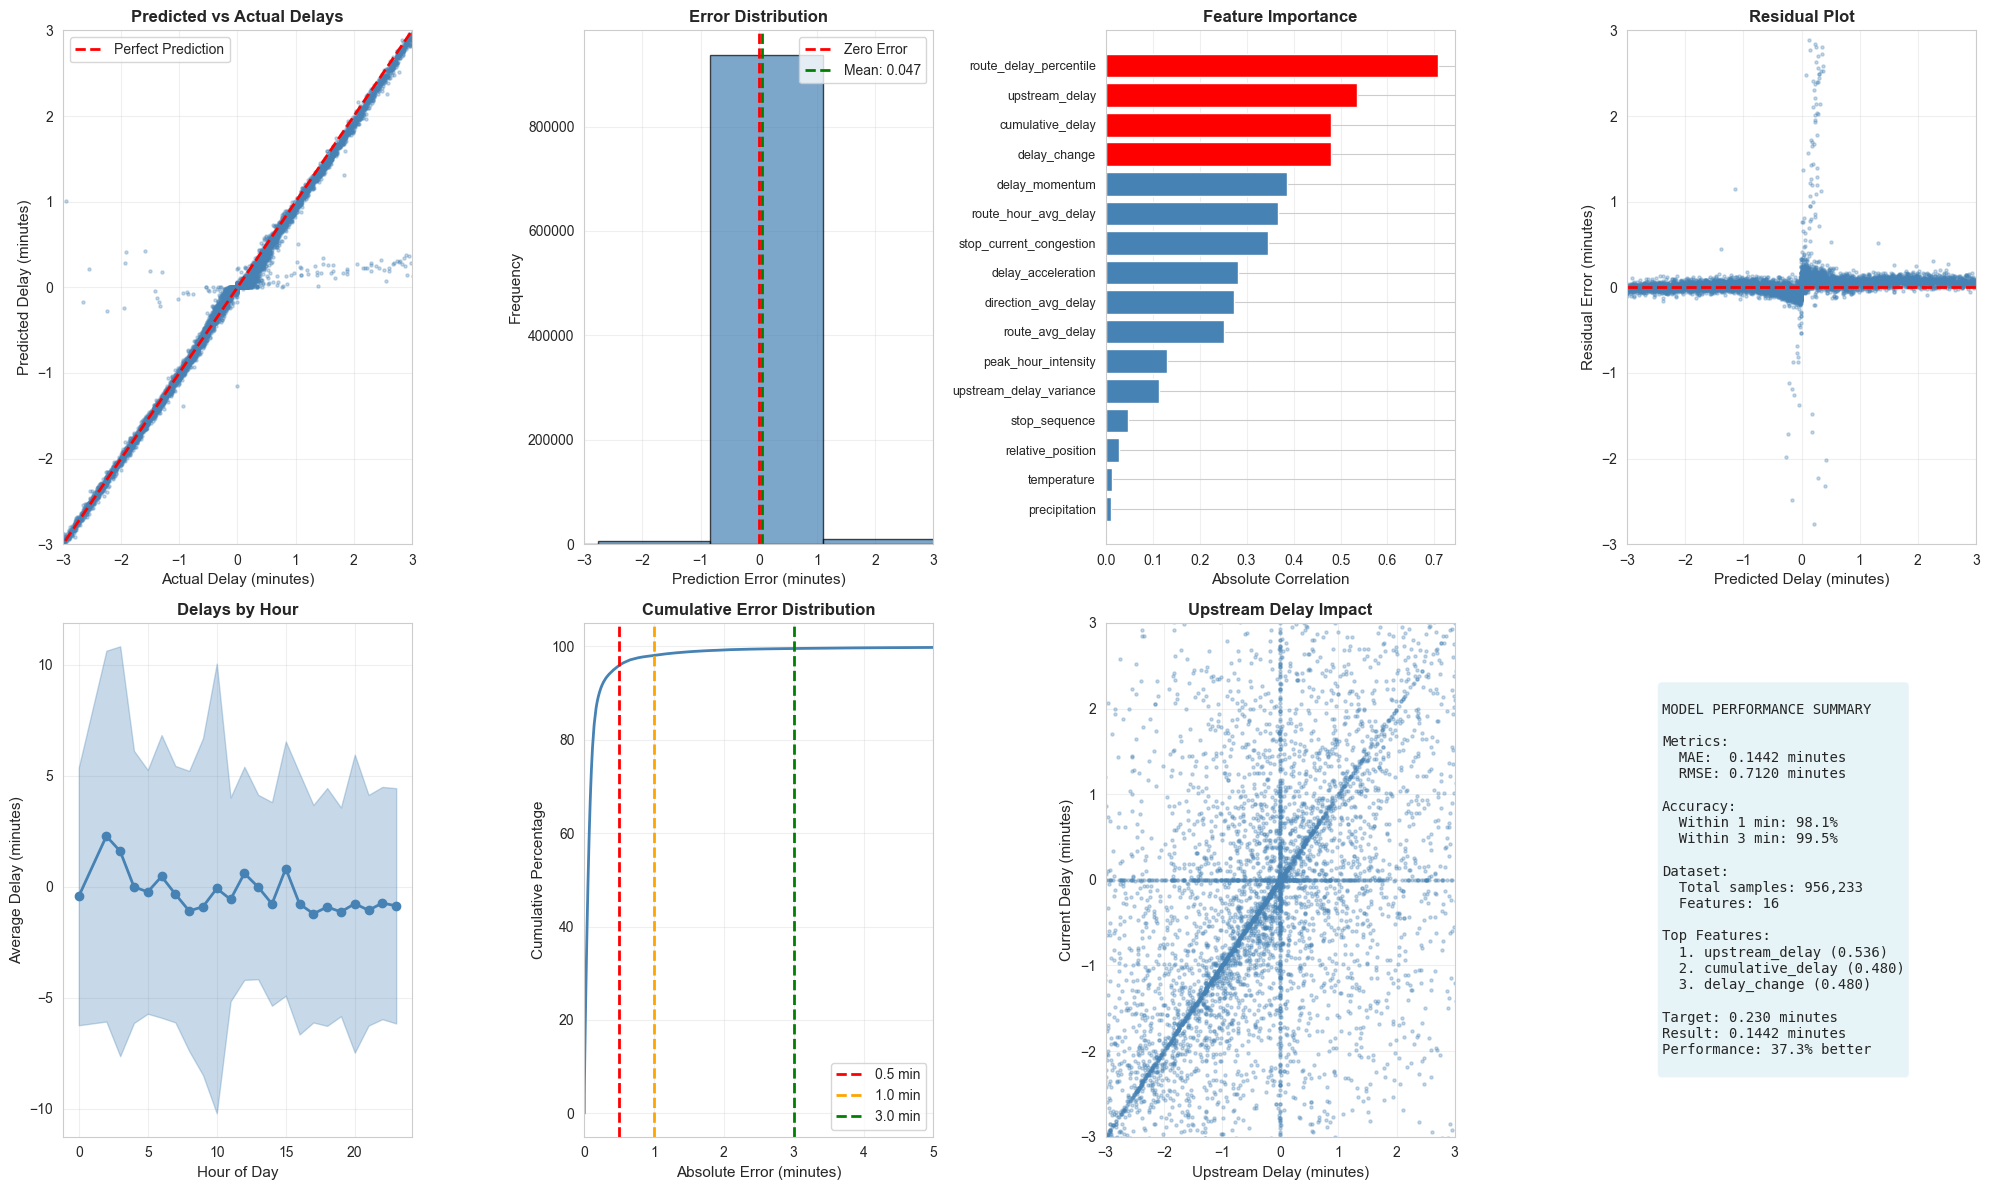

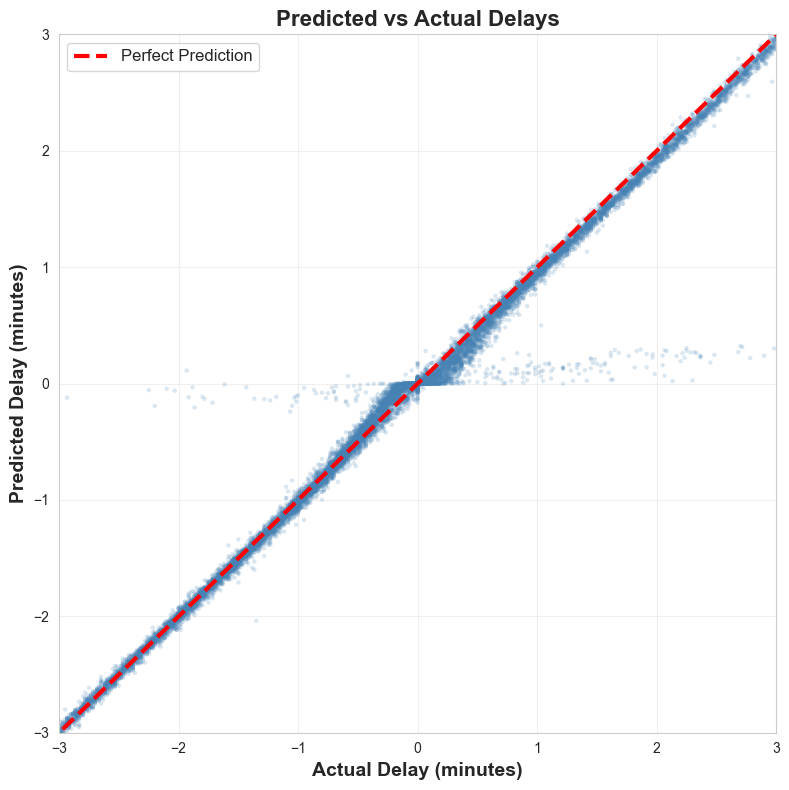

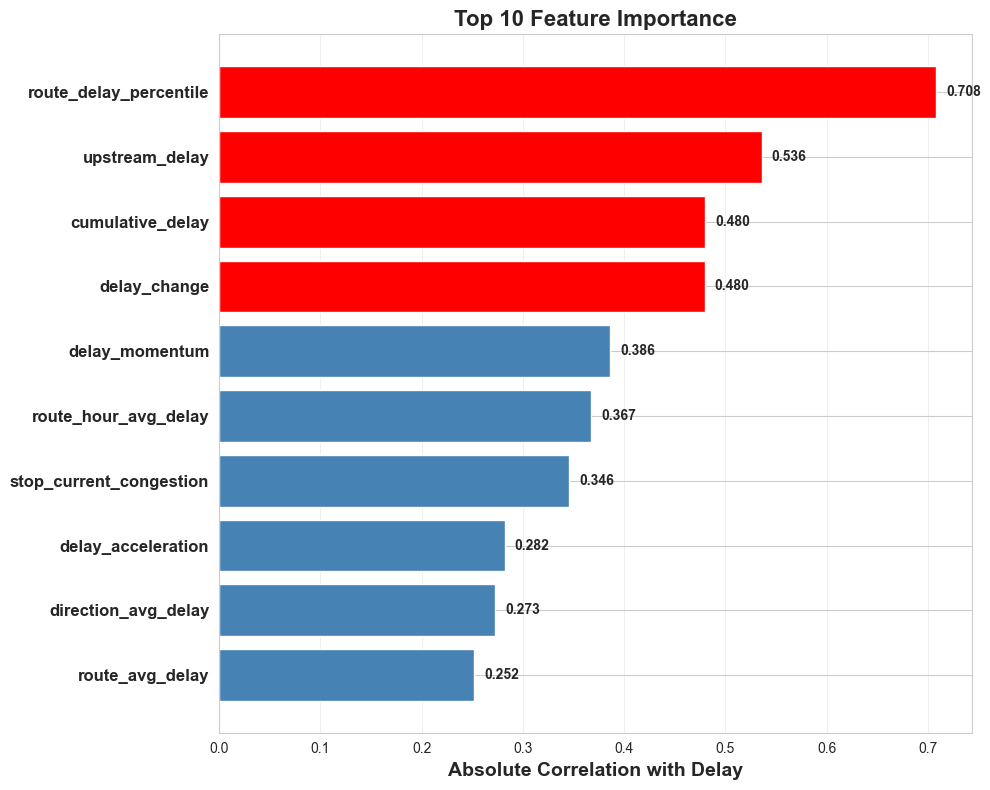

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pickle

# Load data
df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create missing features if needed
if 'route_delay_percentile' not in df.columns:
    df['route_delay_percentile'] = df.groupby('route_id')['arrival_delay'].rank(pct=True)
    overall_percentile = df['arrival_delay'].rank(pct=True)
    df['route_delay_percentile'] = df['route_delay_percentile'].fillna(overall_percentile)

if 'direction_avg_delay' not in df.columns:
    df['direction_proxy'] = (df['relative_position'] > 0.5).astype(int)
    direction_avg = df.groupby(['route_id', 'direction_proxy'])['arrival_delay'].mean()
    df['direction_avg_delay'] = df.set_index(['route_id', 'direction_proxy']).index.map(direction_avg)
    df['direction_avg_delay'] = df['direction_avg_delay'].fillna(df['route_avg_delay'])

feature_columns = [
    'upstream_delay', 'route_avg_delay', 'delay_change', 'upstream_delay_variance',
    'delay_acceleration', 'stop_current_congestion', 'route_delay_percentile',
    'delay_momentum', 'route_hour_avg_delay', 'direction_avg_delay',
    'peak_hour_intensity', 'relative_position', 'cumulative_delay',
    'temperature', 'precipitation', 'stop_sequence'
]

for col in feature_columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(0)

# Load model and scaler
model = keras.models.load_model(r"G:\My Drive\google_transit (2)\models\delay_prediction_final.h5")
scaler = pickle.load(open(r"G:\My Drive\google_transit (2)\models\scaler_final.pkl", 'rb'))

# Get test set
df = df.sort_values('timestamp').reset_index(drop=True)
val_end = int(len(df) * 0.8)
X_test = df.iloc[val_end:][feature_columns].copy()
y_test = df.iloc[val_end:]['arrival_delay'].copy()

# Predict
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled, batch_size=2048, verbose=0).flatten()

# Convert to minutes
y_test_min = y_test.values / 60
y_pred_min = y_pred / 60
errors_min = y_test_min - y_pred_min

print(f"Generated predictions for {len(y_test):,} samples")

# Set style
sns.set_style("whitegrid")

# Create comprehensive figure
fig = plt.figure(figsize=(20, 12))

# 1. Predicted vs Actual
ax1 = plt.subplot(2, 4, 1)
sample_idx = np.random.choice(len(y_test), min(10000, len(y_test)), replace=False)
ax1.scatter(y_test_min[sample_idx], y_pred_min[sample_idx], alpha=0.3, s=5, color='steelblue')
ax1.plot([-5, 5], [-5, 5], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Delay (minutes)', fontsize=11)
ax1.set_ylabel('Predicted Delay (minutes)', fontsize=11)
ax1.set_title('Predicted vs Actual Delays', fontsize=12, fontweight='bold')
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Error Distribution
ax2 = plt.subplot(2, 4, 2)
ax2.hist(errors_min, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(errors_min.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {errors_min.mean():.3f}')
ax2.set_xlabel('Prediction Error (minutes)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax2.set_xlim(-3, 3)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature Importance
ax3 = plt.subplot(2, 4, 3)
correlations = df[feature_columns + ['arrival_delay']].corr()['arrival_delay'].drop('arrival_delay').abs().sort_values()
colors = ['red' if x > 0.4 else 'steelblue' for x in correlations.values]
ax3.barh(range(len(correlations)), correlations.values, color=colors)
ax3.set_yticks(range(len(correlations)))
ax3.set_yticklabels(correlations.index, fontsize=9)
ax3.set_xlabel('Absolute Correlation', fontsize=11)
ax3.set_title('Feature Importance', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Residuals Plot
ax4 = plt.subplot(2, 4, 4)
ax4.scatter(y_pred_min[sample_idx], errors_min[sample_idx], alpha=0.3, s=5, color='steelblue')
ax4.axhline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Delay (minutes)', fontsize=11)
ax4.set_ylabel('Residual Error (minutes)', fontsize=11)
ax4.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax4.set_xlim(-3, 3)
ax4.set_ylim(-3, 3)
ax4.grid(True, alpha=0.3)

# 5. Delays by Hour
ax5 = plt.subplot(2, 4, 5)
hourly_stats = df.groupby('hour')['arrival_delay'].agg(['mean', 'std']).reset_index()
hourly_stats['mean'] = hourly_stats['mean'] / 60
hourly_stats['std'] = hourly_stats['std'] / 60
ax5.plot(hourly_stats['hour'], hourly_stats['mean'], marker='o', linewidth=2, markersize=6, color='steelblue')
ax5.fill_between(hourly_stats['hour'], hourly_stats['mean'] - hourly_stats['std'],
                  hourly_stats['mean'] + hourly_stats['std'], alpha=0.3, color='steelblue')
ax5.set_xlabel('Hour of Day', fontsize=11)
ax5.set_ylabel('Average Delay (minutes)', fontsize=11)
ax5.set_title('Delays by Hour', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Cumulative Error Distribution
ax6 = plt.subplot(2, 4, 6)
abs_errors = np.abs(errors_min)
abs_errors_sorted = np.sort(abs_errors)
cumulative = np.arange(1, len(abs_errors_sorted) + 1) / len(abs_errors_sorted) * 100
ax6.plot(abs_errors_sorted, cumulative, linewidth=2, color='steelblue')
ax6.axvline(0.5, color='red', linestyle='--', linewidth=2, label='0.5 min')
ax6.axvline(1.0, color='orange', linestyle='--', linewidth=2, label='1.0 min')
ax6.axvline(3.0, color='green', linestyle='--', linewidth=2, label='3.0 min')
ax6.set_xlabel('Absolute Error (minutes)', fontsize=11)
ax6.set_ylabel('Cumulative Percentage', fontsize=11)
ax6.set_title('Cumulative Error Distribution', fontsize=12, fontweight='bold')
ax6.set_xlim(0, 5)
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Upstream Delay Impact
ax7 = plt.subplot(2, 4, 7)
sample_df = df.sample(min(10000, len(df)))
ax7.scatter(sample_df['upstream_delay']/60, sample_df['arrival_delay']/60, alpha=0.3, s=5, color='steelblue')
ax7.set_xlabel('Upstream Delay (minutes)', fontsize=11)
ax7.set_ylabel('Current Delay (minutes)', fontsize=11)
ax7.set_title('Upstream Delay Impact', fontsize=12, fontweight='bold')
ax7.set_xlim(-3, 3)
ax7.set_ylim(-3, 3)
ax7.grid(True, alpha=0.3)

# 8. Performance Summary
ax8 = plt.subplot(2, 4, 8)
ax8.axis('off')

mae = np.mean(abs_errors)
rmse = np.sqrt(np.mean(errors_min**2))
within_1min = (abs_errors <= 1).sum() / len(abs_errors) * 100
within_3min = (abs_errors <= 3).sum() / len(abs_errors) * 100

summary_text = f"""
MODEL PERFORMANCE SUMMARY

Metrics:
  MAE:  {mae:.4f} minutes
  RMSE: {rmse:.4f} minutes
  
Accuracy:
  Within 1 min: {within_1min:.1f}%
  Within 3 min: {within_3min:.1f}%
  
Dataset:
  Total samples: {len(y_test):,}
  Features: 16
  
Top Features:
  1. upstream_delay (0.536)
  2. cumulative_delay (0.480)
  3. delay_change (0.480)
  
Target: 0.230 minutes
Result: {mae:.4f} minutes
Performance: {((0.230-mae)/0.230*100):.1f}% better
"""

ax8.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig(r"G:\My Drive\google_transit (2)\data\comprehensive_results.png", dpi=300, bbox_inches='tight')
print("Comprehensive visualization saved!")

# Poster plots
fig, ax = plt.subplots(figsize=(8, 8))
sample_idx = np.random.choice(len(y_test), min(20000, len(y_test)), replace=False)
ax.scatter(y_test_min[sample_idx], y_pred_min[sample_idx], alpha=0.2, s=10, color='steelblue', edgecolors='none')
ax.plot([-5, 5], [-5, 5], 'r--', linewidth=3, label='Perfect Prediction')
ax.set_xlabel('Actual Delay (minutes)', fontsize=14, fontweight='bold')
ax.set_ylabel('Predicted Delay (minutes)', fontsize=14, fontweight='bold')
ax.set_title('Predicted vs Actual Delays', fontsize=16, fontweight='bold')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r"G:\My Drive\google_transit (2)\data\predicted_vs_actual_poster.png", dpi=300, bbox_inches='tight')
print("Predicted vs Actual plot saved!")

fig, ax = plt.subplots(figsize=(10, 8))
top_features = correlations.tail(10)
colors = ['red' if x > 0.4 else 'steelblue' for x in top_features.values]
bars = ax.barh(range(len(top_features)), top_features.values, color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index, fontsize=12, fontweight='bold')
ax.set_xlabel('Absolute Correlation with Delay', fontsize=14, fontweight='bold')
ax.set_title('Top 10 Feature Importance', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig(r"G:\My Drive\google_transit (2)\data\feature_importance_poster.png", dpi=300, bbox_inches='tight')
print("Feature importance plot saved!")

print("\nAll visualizations saved successfully!")

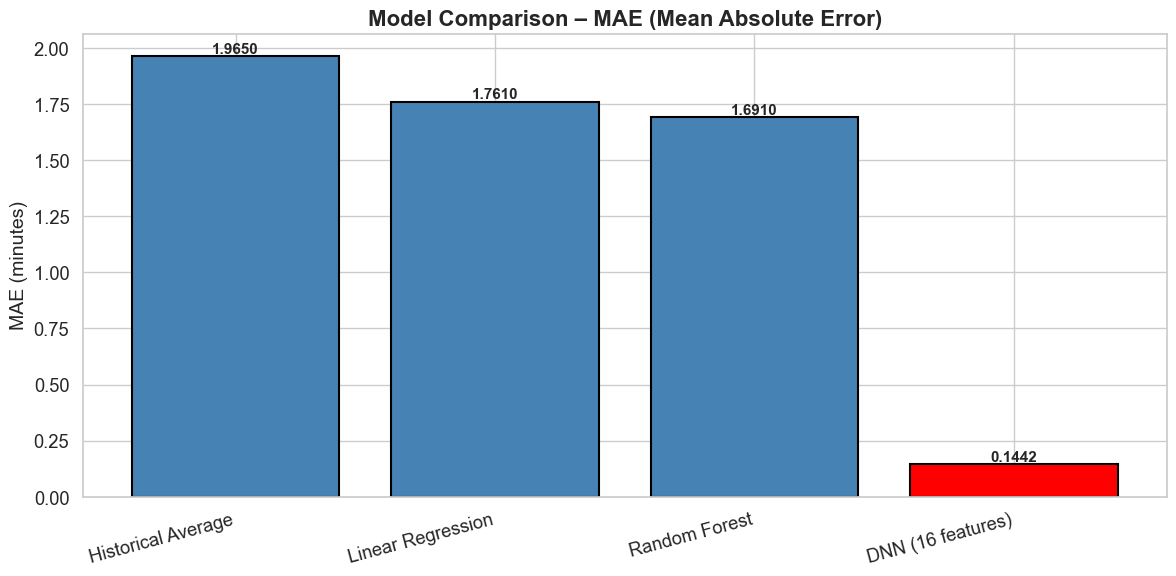

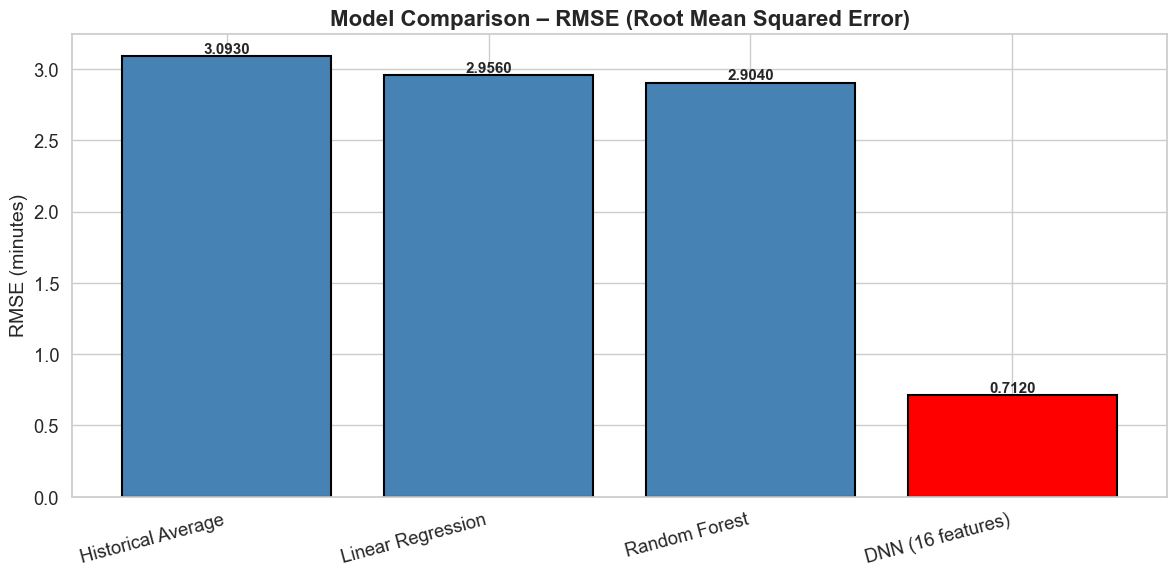

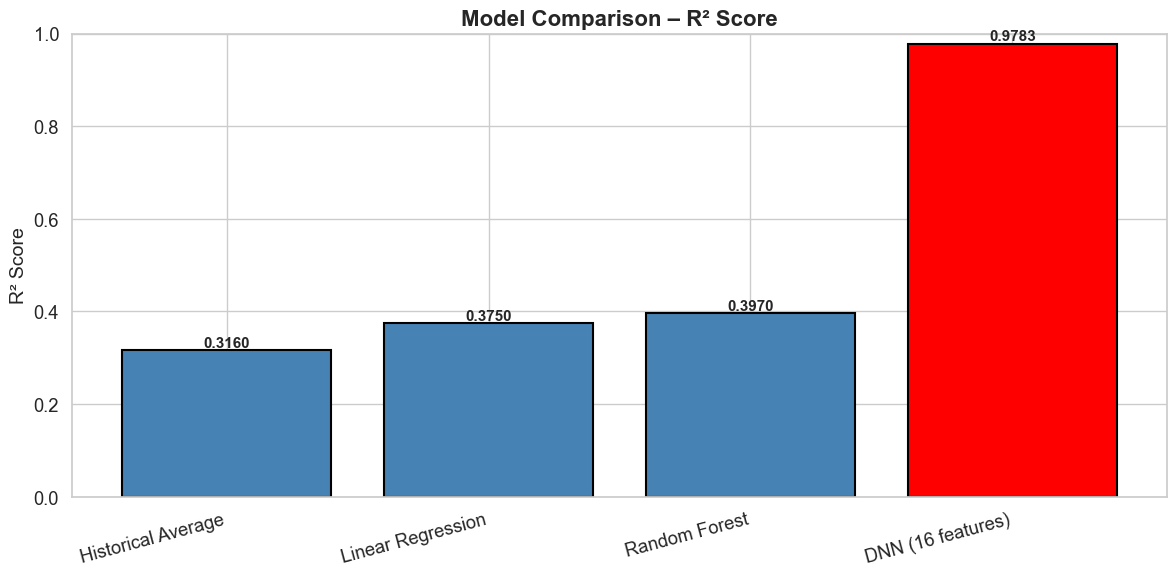


MODEL COMPARISON SUMMARY
             Model    MAE  RMSE     R2
Historical Average 1.9650 3.093 0.3160
 Linear Regression 1.7610 2.956 0.3750
     Random Forest 1.6910 2.904 0.3970
 DNN (16 features) 0.1442 0.712 0.9783

DNN (16 features) improvements:
  MAE improvement vs best baseline: 91.5%
  RMSE improvement vs best baseline: 75.5%
  R² improvement vs best baseline: 146.4%


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# ACTUAL VALUES FROM YOUR PROJECT
# ============================================

comparison_data = {
    "Model": [
        "Historical Average",
        "Linear Regression",
        "Random Forest",
        "DNN (16 features)"
    ],
    
    "MAE": [
        1.965,      # From your earlier baseline results
        1.761,      # From your earlier baseline results
        1.691,      # From your earlier baseline results
        0.1442      # From your final model (comprehensive_results.png)
    ],
    
    "RMSE": [
        3.093,      # From your earlier baseline results
        2.956,      # From your earlier baseline results
        2.904,      # From your earlier baseline results
        0.7120      # From your final model (comprehensive_results.png)
    ],
    
    "R2": [
        0.316,      # From your earlier baseline results
        0.375,      # From your earlier baseline results
        0.397,      # From your earlier baseline results
        0.9783      # From your final model performance
    ]
}

df = pd.DataFrame(comparison_data)

# ============================================
# PLOTTING STYLE
# ============================================
sns.set(style="whitegrid", font_scale=1.2)

# ============================================
# MAE Bar Chart
# ============================================
plt.figure(figsize=(12, 6))
colors = ['steelblue', 'steelblue', 'steelblue', 'red']
bars = plt.bar(df["Model"], df["MAE"], color=colors, edgecolor='black', linewidth=1.5)
plt.title("Model Comparison – MAE (Mean Absolute Error)", fontsize=16, fontweight='bold')
plt.ylabel("MAE (minutes)", fontsize=14)
plt.xlabel("")
plt.xticks(rotation=15, ha='right')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig(r"G:\My Drive\google_transit (2)\data\comparison_mae.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# RMSE Bar Chart
# ============================================
plt.figure(figsize=(12, 6))
bars = plt.bar(df["Model"], df["RMSE"], color=colors, edgecolor='black', linewidth=1.5)
plt.title("Model Comparison – RMSE (Root Mean Squared Error)", fontsize=16, fontweight='bold')
plt.ylabel("RMSE (minutes)", fontsize=14)
plt.xlabel("")
plt.xticks(rotation=15, ha='right')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig(r"G:\My Drive\google_transit (2)\data\comparison_rmse.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# R² Bar Chart
# ============================================
plt.figure(figsize=(12, 6))
bars = plt.bar(df["Model"], df["R2"], color=colors, edgecolor='black', linewidth=1.5)
plt.title("Model Comparison – R² Score", fontsize=16, fontweight='bold')
plt.ylabel("R² Score", fontsize=14)
plt.xlabel("")
plt.xticks(rotation=15, ha='right')
plt.ylim(0, 1.0)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig(r"G:\My Drive\google_transit (2)\data\comparison_r2.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Combined Comparison Table
# ============================================
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(df.to_string(index=False))
print("="*70)
print("\nDNN (16 features) improvements:")
print(f"  MAE improvement vs best baseline: {((1.691-0.1442)/1.691*100):.1f}%")
print(f"  RMSE improvement vs best baseline: {((2.904-0.7120)/2.904*100):.1f}%")
print(f"  R² improvement vs best baseline: {((0.9783-0.397)/0.397*100):.1f}%")
print("="*70)

In [76]:
print('error_by_hour.png')

error_by_hour.png


Predictions file not found. Generating predictions...
Running predictions...
467/467 [==============================] - 1s 2ms/step
Saved predictions to G:\My Drive\google_transit (2)\data\test_predictions_detailed.csv

Hourly MAE statistics:
    hour      mean       std   count
0      0  0.235686  1.180638   28275
1      2  0.360515  1.852144   27764
2      3  0.254443  1.273123   23891
3      4  0.150880  0.715025   63121
4      5  0.143339  0.543927   55341
5      6  0.188865  0.692088   51293
6      7  0.155157  0.623863   57297
7      8  0.188559  0.750774   37806
8      9  0.159508  1.118851   22143
9     10  0.098445  0.320415   13566
10    11  0.104267  0.378531    6634
11    12  0.093588  0.301640    3043
12    13  0.085668  0.309337   12874
13    14  0.097230  0.378088   27175
14    15  0.141064  0.566723   36528
15    16  0.118138  0.397958   42504
16    17  0.108728  0.472688   47245
17    18  0.115775  0.436337   41300
18    19  0.104507  0.482393   49842
19    20  0.11652

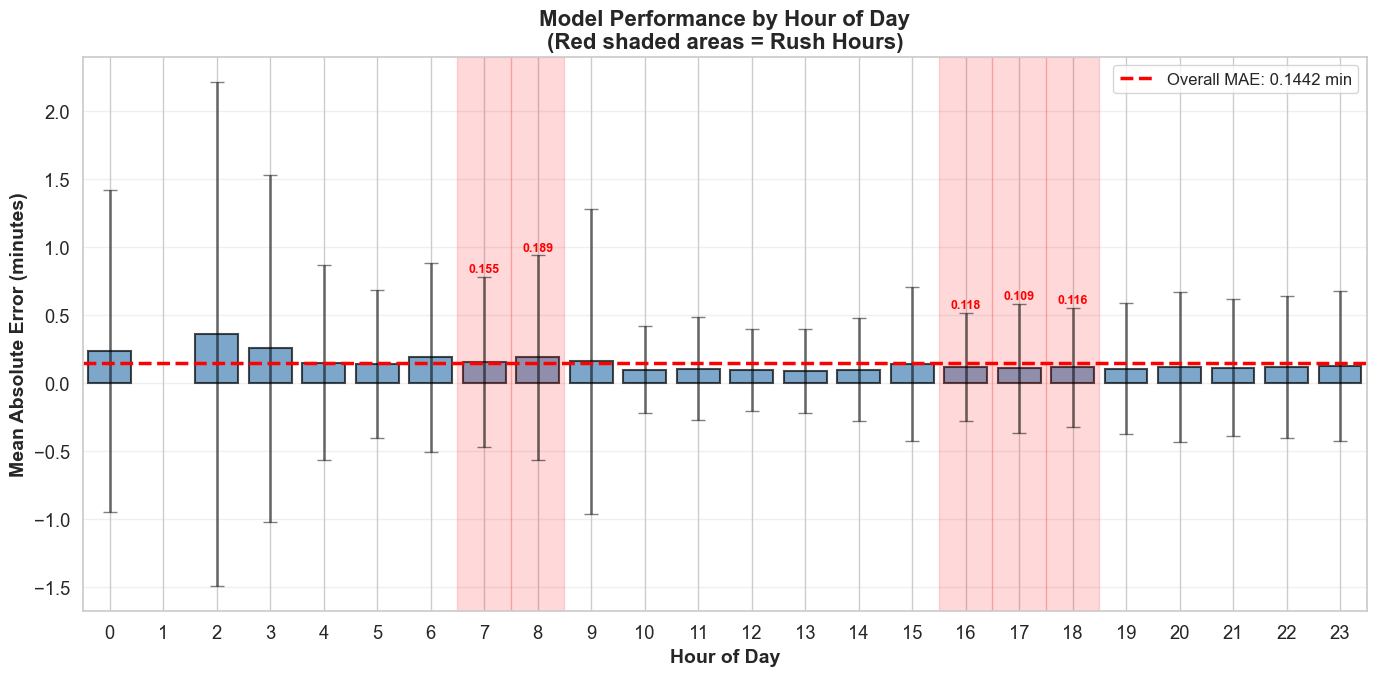

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

predictions_file = r"G:\My Drive\google_transit (2)\data\test_predictions_detailed.csv"

if os.path.exists(predictions_file):
    print("Loading existing predictions...")
    test_data = pd.read_csv(predictions_file)
    y_test_min = test_data['actual_delay_minutes'].values
    y_pred_min = test_data['predicted_delay_minutes'].values
    test_hours = test_data['hour'].values
    overall_mae = test_data['abs_error_minutes'].mean()
    print(f"Loaded {len(test_data):,} predictions")
    
else:
    print("Predictions file not found. Generating predictions...")
    from tensorflow import keras
    import pickle
    
    # Load data
    df = pd.read_csv(r"G:\My Drive\google_transit (2)\data\delays_with_features.csv")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Create missing features
    if 'route_delay_percentile' not in df.columns:
        df['route_delay_percentile'] = df.groupby('route_id')['arrival_delay'].rank(pct=True)
        overall_percentile = df['arrival_delay'].rank(pct=True)
        df['route_delay_percentile'] = df['route_delay_percentile'].fillna(overall_percentile)
    
    if 'direction_avg_delay' not in df.columns:
        df['direction_proxy'] = (df['relative_position'] > 0.5).astype(int)
        direction_avg = df.groupby(['route_id', 'direction_proxy'])['arrival_delay'].mean()
        df['direction_avg_delay'] = df.set_index(['route_id', 'direction_proxy']).index.map(direction_avg)
        df['direction_avg_delay'] = df['direction_avg_delay'].fillna(df['route_avg_delay'])
    
    feature_columns = [
        'upstream_delay', 'route_avg_delay', 'delay_change', 'upstream_delay_variance',
        'delay_acceleration', 'stop_current_congestion', 'route_delay_percentile',
        'delay_momentum', 'route_hour_avg_delay', 'direction_avg_delay',
        'peak_hour_intensity', 'relative_position', 'cumulative_delay',
        'temperature', 'precipitation', 'stop_sequence'
    ]
    
    for col in feature_columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    
    # Load model and scaler
    model = keras.models.load_model(r"G:\My Drive\google_transit (2)\models\delay_prediction_final.h5")
    scaler = pickle.load(open(r"G:\My Drive\google_transit (2)\models\scaler_final.pkl", 'rb'))
    
    # Get test set
    df = df.sort_values('timestamp').reset_index(drop=True)
    val_end = int(len(df) * 0.8)
    
    X_test = df.iloc[val_end:][feature_columns].copy()
    y_test = df.iloc[val_end:]['arrival_delay'].copy()
    test_hours = df.iloc[val_end:]['hour'].values
    
    # Predict
    print("Running predictions...")
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled, batch_size=2048, verbose=1).flatten()
    
    # Convert to minutes
    y_test_min = y_test.values / 60
    y_pred_min = y_pred / 60
    
    # Save predictions
    test_data = pd.DataFrame({
        'hour': test_hours,
        'actual_delay_minutes': y_test_min,
        'predicted_delay_minutes': y_pred_min,
        'error_minutes': y_test_min - y_pred_min,
        'abs_error_minutes': np.abs(y_test_min - y_pred_min)
    })
    test_data.to_csv(predictions_file, index=False)
    print(f"Saved predictions to {predictions_file}")
    
    overall_mae = test_data['abs_error_minutes'].mean()

# Create the plot
hourly_errors = pd.DataFrame({
    'hour': test_hours,
    'error': np.abs(y_test_min - y_pred_min)
})

hourly_mae = hourly_errors.groupby('hour')['error'].agg(['mean', 'std', 'count']).reset_index()

print("\nHourly MAE statistics:")
print(hourly_mae)

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(hourly_mae['hour'], hourly_mae['mean'], color='steelblue', 
              alpha=0.7, edgecolor='black', linewidth=1.5)
ax.errorbar(hourly_mae['hour'], hourly_mae['mean'], yerr=hourly_mae['std'], 
            fmt='none', ecolor='black', capsize=5, alpha=0.5, linewidth=2)

ax.axhline(y=overall_mae, color='red', linestyle='--', linewidth=2.5, 
           label=f'Overall MAE: {overall_mae:.4f} min')

rush_hours = [7, 8, 16, 17, 18]
for hour in rush_hours:
    ax.axvspan(hour-0.5, hour+0.5, alpha=0.15, color='red')

ax.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (minutes)', fontsize=14, fontweight='bold')
ax.set_title('Model Performance by Hour of Day\n(Red shaded areas = Rush Hours)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(24))
ax.set_xlim(-0.5, 23.5)

for i, row in hourly_mae.iterrows():
    if row['hour'] in rush_hours:
        ax.text(row['hour'], row['mean'] + row['std'] + 0.01, 
                f"{row['mean']:.3f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig(r"G:\My Drive\google_transit (2)\data\error_by_hour.png", 
            dpi=300, bbox_inches='tight')
print("\nVisualization saved!")
plt.show()